<p align="center">
 <img src="http://www.di.uoa.gr/themes/corporate_lite/logo_en.png" title="Department of Informatics and Telecommunications - University of Athens"/> </p>

<br>

---

<h3 align="center" > 
  Bachelor Thesis
</h3>

<h1 align="center" > 
  Entity Resolution in Dissimilarity Spaces <br>
  Implementation notebook
</h1>

---

<h3 align="center"> 
 <b>Konstantinos Nikoletos</b>
</h3>

<h4 align="center"> 
 <b>Supervisors:<br> Dr. Alex Delis</b>,  Professor NKUA <br> <b> Dr. Vassilis Verikios</b>, Professor Hellenic Open University

</h4>
<br>
<h4 align="center"> 
Athens
</h4>
<h4 align="center"> 
January 2021 - Ongoing
</h4>


---

# __Implementation__

## __0.0 Install components__

In [1]:
!pip install editdistance

In [2]:
!pip install pandas
import pandas as pd
print(pd.__version__)

1.0.1


In [3]:
!pip install pandas_read_xml

  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.25.11
    Uninstalling urllib3-1.25.11:
      Successfully uninstalled urllib3-1.25.11


ERROR: requests 2.22.0 has requirement urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you'll have urllib3 1.26.6 which is incompatible.
ERROR: botocore 1.12.189 has requirement urllib3<1.26,>=1.20, but you'll have urllib3 1.26.6 which is incompatible.


In [4]:
!pip install requests

  Using cached urllib3-1.25.11-py2.py3-none-any.whl (127 kB)
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.6
    Uninstalling urllib3-1.26.6:
      Successfully uninstalled urllib3-1.26.6


ERROR: pandas-read-xml 0.3.1 has requirement urllib3>=1.26.3, but you'll have urllib3 1.25.11 which is incompatible.


## __0.1 Import libraries__

In [1]:
import pandas as pd
import numpy as np
import collections
import editdistance
import string
import sklearn
import pandas_read_xml as pdx
import time
import warnings
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import math

from tqdm.notebook import tqdm as tqdm
from scipy.spatial.distance import directed_hausdorff,hamming
from scipy.stats._stats import _kendall_dis
from scipy.stats import spearmanr,kendalltau,pearsonr,kruskal,mannwhitneyu
from sklearn.metrics.pairwise import cosine_similarity
from nltk.metrics.distance import jaro_similarity,jaro_winkler_similarity,jaccard_distance
from sklearn.metrics import jaccard_score,accuracy_score,auc,f1_score,recall_score,precision_score,classification_report
from scipy.sparse import csr_matrix
from scipy import sparse
from scipy import stats 
from scipy.spatial.distance import euclidean,hamming
from matplotlib.patches import Rectangle
from sklearn.metrics import ndcg_score

plt.style.use('seaborn-whitegrid') # plot style

## __Final model__









In [40]:
class RankedWTAHash:

  def __init__(self, max_numberOf_clusters, max_editDistance, windowSize, number_of_permutations=1, min_numOfNodes = 2,jaccard_withchars =True,distanceMetricEmbedding = 'l_inf', metric = 'kendal', similarityVectors='ranked', distanceMetric = 'edit', ngramms=3, similarityThreshold=None, maxOnly=None ):
    '''
      Constructor
    '''
    self.max_numberOf_clusters = max_numberOf_clusters
    self.pairDictionary = dict()
    self.max_editDistance = max_editDistance
    self.windowSize = windowSize
    self.S_set = None 
    self.S_index = None 
    self.similarityThreshold = similarityThreshold
    self.maxOnly = maxOnly
    self.metric = metric
    self.min_numOfNodes = min_numOfNodes
    self.similarityVectors = similarityVectors
    self.number_of_permutations = number_of_permutations
    self.distanceMetric = distanceMetric
    self.distanceMetricEmbedding = distanceMetricEmbedding
    self.ngramms = ngramms
    self.jaccard_withchars =  jaccard_withchars
  
  def fit(self, X):
    """
      Fit the classifier from the training dataset.
      Parameters
      ----------
      X : Training data.
      Returns
      -------
      self : The fitted classifier.
    """
    print("\n#####################################################################\n#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #\n#####################################################################\n")

    if isinstance(X, list):
      input_strings = X
    else:
      input_strings = list(X)

    # print(input_strings)
    self.initialS_set = np.array(input_strings,dtype=object)
    self.S_set = np.array(input_strings,dtype=object)
    if self.distanceMetric == 'jaccard' and self.jaccard_withchars == False:    
      for i in range(0,len(input_strings)):
        self.S_set[i] = set(nltk.ngrams(nltk.word_tokenize(data[i]), n=self.ngramms))
    elif self.distanceMetric == 'jaccard' and self.jaccard_withchars == True:    
      for i in range(0,len(input_strings)):
        self.S_set[i] = set(nltk.ngrams(data[i], n=self.ngramms))
    # print(self.S_set)

    self.S_index = np.arange(0,len(input_strings),1)

    # print("\n\nString positions are:")
    # print(self.S_index)
    # print("\n")

    print("###########################################################\n# > 1. Prototype selection phase                          #\n###########################################################\n")
    print("\n-> Finding prototypes and representatives of each cluster:")
    prototypes_time = time.time()
    self.prototypeArray,self.selected_numOfPrototypes = self.Clustering_Prototypes(self.S_index,self.max_numberOf_clusters, self.max_editDistance, self.pairDictionary)
    print("\n- Prototypes selected")
    self.embeddingDim = self.prototypeArray.size
    print(self.prototypeArray)
    heatmapData = []
    for pr in self.prototypeArray:
        print(pr," -> ",self.initialS_set[pr])
        heatmapData.append(self.S_set[pr])
    myHeatmap(self.prototypeArray,self.metric,self.EditDistance)
    print("\n- Final number of prototypes: ",self.selected_numOfPrototypes )
    prototypes_time = time.time() - prototypes_time
    print("\n# Finished in %.6s secs" % (prototypes_time))
    print("\n")
    return None
    print("###########################################################\n# > 2. Embeddings based on the Vantage objects            #\n###########################################################\n")
    print("\n-> Creating Embeddings:")
    embeddings_time = time.time()
    self.Embeddings = self.CreateVantageEmbeddings(self.S_index,self.prototypeArray, self.pairDictionary)
    print("- Embeddings created")
    print(self.Embeddings)
    embeddings_time = time.time() - embeddings_time
    print("\n# Finished in %.6s secs" % (embeddings_time))
    print("\n")


    print("###########################################################\n# > 3. WTA Hashing                                        #\n###########################################################\n")
    print("\n-> Creating WTA Buckets:")
    wta_time = time.time()
    self.HashedClusters,self.buckets,self.rankedVectors = self.WTA(self.Embeddings,self.windowSize,self.embeddingDim, self.number_of_permutations)
    print("- WTA buckets: ")
    for key in self.buckets.keys():
      print(key," -> ",self.buckets[key])
    print("\n- WTA number of buckets: ", len(self.buckets.keys()))
    print("\n- WTA RankedVectors after permutation:")
    print(self.rankedVectors)
    wta_time = time.time() - wta_time
    print("\n# Finished in %.6s secs" % (wta_time))
    print("\n")

    print("###########################################################\n# > 4. Similarity checking                                #\n###########################################################\n")
    print("\n-> Similarity checking:")
    if len(self.buckets.keys()) < 8:
        return None
    
    similarity_time = time.time()

    if self.similarityVectors == 'ranked':
      self.mapping,self.mapping_matrix = self.SimilarityEvaluation(self.buckets,self.rankedVectors,self.similarityThreshold,maxOnly=self.maxOnly, metric=self.metric)
    elif self.similarityVectors == 'initial':
      self.mapping,self.mapping_matrix = self.SimilarityEvaluation(self.buckets,self.Embeddings,self.similarityThreshold,maxOnly=self.maxOnly, metric=self.metric)      
    else:
      warnings.warn("similarityVectors: Available options are: ranked,initial")
#     print("- Similarity matrix (all values compared):")
#     print(self.similarityProb_matrix)
    print("- Similarity mapping in a matrix")
    print(self.mapping_matrix)
    similarity_time = time.time() - similarity_time
    print("\n# Finished in %.6s secs" % (similarity_time))
    print("\n#####################################################################\n#                    .~ End of training ~.                          #\n#####################################################################\n")

    return self

  def EditDistance(self, str1,str2,verbose=False):
      if verbose:
        if str1 == None:
            print("1")
        elif str2 == None:
            print("2")
        print("-> "+str(str1))
        print("--> "+str(str2))
        print(str(editdistance.eval(self.S_set[str1],self.S_set[str2])))
      
      
      # NOTE: Duplicates inside the dictionary     

      if ((str1,str2) or (str2,str1))  in self.pairDictionary.keys():
        return self.pairDictionary[(str1,str2)]
      else:
        # if verbose:
        # print("++++++++++")
        # print(str1,str2)
        # print(self.S_set[str1],self.S_set[str2])
        # print("++++++++++")
        if self.distanceMetric == 'edit':
            distance = editdistance.eval(self.S_set[str1],self.S_set[str2])
        elif self.distanceMetric == 'jaccard':
            distance = jaccard_distance(self.S_set[str1],self.S_set[str2])
#             # jaccard because we want DISSIMILARITY 
#             print("-> "+str(self.initialS_set[str1]))
#             print("--> "+str(self.initialS_set[str2]))
#             print(distance)
        else:
            warnings.warn("Available metrics for space creation: edit, jaccard ")
        self.pairDictionary[(str2,str1)] = self.pairDictionary[(str1,str2)] = distance
        return distance

  #####################################################################
  # 1. Prototype selection algorithm                                  #
  #####################################################################

  '''
  Clustering_Prototypes(S,k,d,r,C) 
  The String Clustering and Prototype Selection Algorithm
  is the main clustering method, that takes as input the intial strings S, 
  the max number of clusters to be generated in k,
  the maximum allowable distance of a string to join a cluster in var d
  and returns the prototype for each cluster in array Prototype
  '''
  def Clustering_Prototypes(self,S,k,d,pairDictionary,verbose=False):
      
      # ----------------- Initialization phase ----------------- #
      i = 0
      j = 0
      C = np.empty([S.size], dtype=int)
      r = np.empty([2,k],dtype=object)

      Clusters = [ [] for l in range(0,k)]

      for i in tqdm(range(0,S.size,1)):     # String-clustering phase, for all strings
          while j < k :       # iteration through clusters, for all clusters
              if r[0][j] == None:      # case empty first representative for cluster j
                  r[0][j] = S[i]   # init cluster representative with string i
                  C[i] = j         # store in C that i-string belongs to cluster j
                  Clusters[j].append(S[i])
                  break
              elif r[1][j] == None and (self.EditDistance(S[i],r[0][j]) <= d):  # case empty second representative 
                  r[1][j] = S[i]                                             # and ED of representative 1  smaller than i-th string 
                  C[i] = j
                  Clusters[j].append(S[i])
                  break
              elif (r[0][j] != None and r[1][j] != None) and (self.EditDistance(S[i],r[0][j]) + self.EditDistance(S[i],r[1][j])) <= d:
                  C[i] = j
                  Clusters[j].append(S[i])
                  break
              else:
                  j += 1
          i += 1

      # ----------------- Prototype selection phase ----------------- #
          
      Projections = np.empty([k],dtype=object)
      Prototypes = np.empty([k],dtype=int)
      sortedProjections = np.empty([k],dtype=object)

      Projections = []
      Prototypes = []
      sortedProjections = []

      if verbose:
          print("- - - - - - - - -")
          print("Cluster array:")
          print(C)
          print("- - - - - - - - -")
          print("Represantatives array:")
          print(r)
          print("- - - - - - - - -")  
          print("Clusters:")
          print(Clusters)
          print("- - - - - - - - -")  

      new_numofClusters = k

      # print("\n\n\n****** Prototype selection phase *********") 
      prototype_index = 0
      for j in range(0,k,1):
          
          # IF small cluster
          # print("Len ",len(Clusters[j]))
          if len(Clusters[j]) < self.min_numOfNodes or r[1][j] == None or r[0][j]==None:
            new_numofClusters-=1
            continue

          Projections.append(self.Approximated_Projection_Distances_ofCluster(r[1][j], r[0][j], j, Clusters[j],pairDictionary))         
          # print(Projections[prototype_index])
          sortedProjections.append({new_numofClusters: v for new_numofClusters, v in sorted(Projections[prototype_index].items(), key=lambda item: item[1])})
          
          
          Prototypes.append(self.Median(sortedProjections[prototype_index]))
          # print(Prototypes[prototype_index])

          prototype_index += 1

      # print("\n****** END *********\n")
      Prototypes,new_numofClusters = self.optimize_clusterSelection(Prototypes,new_numofClusters)
      
      return np.array(Prototypes),new_numofClusters


  def Approximated_Projection_Distances_ofCluster(self, right_rep, left_rep, cluster_id, clusterSet, pairDictionary):
      # print("here")
      # print(clusterSet)
      # print(right_rep, left_rep)

      distances_vector = dict()

      if len(clusterSet) > 2:
        rep_distance     = self.EditDistance(right_rep,left_rep)
                 
        for str_inCluster in range(0,len(clusterSet)): 
          if clusterSet[str_inCluster] != right_rep and clusterSet[str_inCluster] != left_rep:
            # print(clusterSet[str_inCluster],right_rep,left_rep)
            right_rep_distance = self.EditDistance(right_rep,clusterSet[str_inCluster])
            left_rep_distance  = self.EditDistance(left_rep,clusterSet[str_inCluster])
            
            if rep_distance == 0: 
              distances_vector[clusterSet[str_inCluster]] = 0
            else:
              distance = (right_rep_distance**2-rep_distance**2-left_rep_distance**2 ) / (2*rep_distance)
              distances_vector[clusterSet[str_inCluster]] = distance
      
      else:
#         print("set: ",clusterSet)
#         print("left: ",left_rep)
#         print("right: ",right_rep)
        if left_rep != None and right_rep == None:
          distances_vector[left_rep] = left_rep
          # print("l")
        elif right_rep != None and left_rep == None:
          distances_vector[right_rep] = right_rep
          # print("r")
        elif left_rep == None and right_rep == None:
          return None
        elif left_rep != None and right_rep != None:
          distances_vector[right_rep] = right_rep
          distances_vector[left_rep]  = left_rep
      # print(distances_vector)
      return distances_vector

  def Median(self, distances):    
      '''
      Returns the median value of a vector
      '''
      keys = list(distances.keys())
      if keys == 1:
        return keys[0]

      # print(distances)
      keys = list(distances.keys())
      # print(keys)
      median_position = int(len(keys)/2)
      # print(median_position)
      median_value = keys[median_position]

      return median_value
  
  def optimize_clusterSelection(self,Prototypes,numOfPrototypes):
        
        notwantedPrototypes = []
        print(self.max_editDistance/2)
        for pr_1 in range(0,numOfPrototypes):
            for pr_2 in range(pr_1+1,numOfPrototypes):
                if self.EditDistance(Prototypes[pr_1],Prototypes[pr_2]) < 0.7:
                    notwantedPrototypes.append(Prototypes[pr_2]) 
#                     print("-> "+str(self.initialS_set[Prototypes[pr_1]]))
#                     print("--> "+str(self.initialS_set[Prototypes[pr_1]]))
#                     print(self.EditDistance(Prototypes[pr_1],Prototypes[pr_2]))

        newPrototypes = list((set(Prototypes)).difference(set(notwantedPrototypes)))           
        
        print("Prototypes before:")
        print(Prototypes)
        print("Not wanted:")
        print(set(notwantedPrototypes) )
        print("Final:")
        print(newPrototypes)
        return newPrototypes,len(newPrototypes)
  #####################################################################
  #       2. Embeddings based on the Vantage objects                  #
  #####################################################################

  '''
  CreateVantageEmbeddings(S,VantageObjects): Main function for creating the string embeddings based on the Vantage Objects
  '''
  def CreateVantageEmbeddings(self, S, VantageObjects, pairDictionary):
      
      # ------- Distance computing ------- #     
      vectors = []
      for s in tqdm(range(0,S.size)):
          string_embedding = []
          for p in range(0,VantageObjects.size): 
              if VantageObjects[p] != None:
#                   print("-",VantageObjects[p])
                  string_embedding.append(self.DistanceMetric(s,p,S,VantageObjects, pairDictionary))
              
          # --- Ranking representation ---- #
          ranked_string_embedding = stats.rankdata(string_embedding, method='dense')
          
          # ------- Vectors dataset ------- #
          vectors.append(ranked_string_embedding)
      
      return np.array(vectors)
      

  '''
  DistanceMetric(s,p,S,Prototypes): Implementation of equation (5)
  '''
  def DistanceMetric(self, s, p, S, VantageObjects, pairDictionary, distanceMetricEmbedding = 'l_inf'):
      
      if distanceMetricEmbedding == 'l_inf':
          max_distance = None

          for pp in range(0,VantageObjects.size):
              if VantageObjects[pp] != None:
                  string_distance = self.EditDistance(S[s],VantageObjects[pp])    # Edit distance String-i -> Vantage Object
                  VO_distance     = self.EditDistance(VantageObjects[p],VantageObjects[pp])    # Edit distance Vantage Object-j -> Vantage Object-i

                  abs_diff = abs(string_distance-VO_distance)

                  # --- Max distance diff --- #        
                  if max_distance == None:
                      max_distance = abs_diff
                  elif abs_diff > max_distance:
                      max_distance = abs_diff
          return max_distance
    
      elif distanceMetricEmbedding == 'edit':
          return self.EditDistance(S[s],VantageObjects[p])
      elif distanceMetricEmbedding == 'jaccard':
          return jaccard_distance(S[s],VantageObjects[p])
      elif distanceMetricEmbedding == 'euclid_jaccard':
          return sqrt(1-jaccard_distance(S[s],VantageObjects[p]))
      elif distanceMetricEmbedding == 'euclidean':
          return euclidean(S[s],VantageObjects[p])
      else:
          warnings.warn("Available metrics: edit,jaccard,l_inf,euclidean")
        

  def dropNone(array):
      array = list(filter(None, list(array)))
      return np.array(array)

  def topKPrototypes():
      return

  #####################################################################
  #                 3. Similarity checking                            # 
  #####################################################################

  def SimilarityEvaluation(self, buckets,vectors,threshold,maxOnly=None,metric=None):
    
#     print(buckets)
#     print(vectors)
    numOfVectors = vectors.shape[0]
    vectorDim    = vectors.shape[1]
    mapping_matrix = np.zeros([numOfVectors,numOfVectors],dtype=np.int8)
    self.similarityProb_matrix = np.empty([numOfVectors,numOfVectors],dtype=np.float)* np.nan
    mapping = {}

    # Loop for every bucket
    for bucketid in tqdm(buckets.keys()):
      bucket_vectors = buckets[bucketid]
      numOfVectors = len(bucket_vectors)
      
      print(bucket_vectors)
      # For every vector inside the bucket
      for v_index in range(0,numOfVectors,1):
        v_vector_id = bucket_vectors[v_index]
        # Loop to all the other
        for i_index in range(v_index+1,numOfVectors,1):
          i_vector_id = bucket_vectors[i_index]
#           print('v_vector_id: ',v_vector_id,'i_vector_id: ',i_vector_id)
#           print(vectors[v_vector_id], " | ",vectors[i_vector_id])

          if vectorDim == 1:
            warnings.warn("Vector dim equal to 1-Setting metric to kendalltau")
            metric = 'kendal'

          if metric == None or metric == 'kendal':  # Simple Kendal tau metric
            similarity_prob, p_value = kendalltau(vectors[v_vector_id], vectors[i_vector_id])
          elif metric == 'customKendal':  # Custom Kendal tau
            numOf_discordant_pairs = _kendall_dis(vectors[v_vector_id].astype('intp'), vectors[i_vector_id].astype('intp'))
            similarity_prob = (2*numOf_discordant_pairs) / (vectorDim*(vectorDim-1))
          elif metric == 'jaccard':
            similarity_prob = jaccard_score(vectors[v_vector_id], vectors[i_vector_id], average='micro')
          elif metric == 'cosine':
            similarity_prob = cosine_similarity(np.array(vectors[v_vector_id]).reshape(1, -1), np.array(vectors[i_vector_id]).reshape(1, -1))
          elif metric == 'pearson':
            similarity_prob, _ = pearsonr(vectors[v_vector_id], vectors[i_vector_id])
          elif metric == 'spearman':
            similarity_prob, _ = spearmanr(vectors[v_vector_id], vectors[i_vector_id])
          elif metric == 'spearmanf':
            similarity_prob = 1-spearman_footrule_distance(vectors[v_vector_id], vectors[i_vector_id])
          elif metric == 'hamming':
            similarity_prob, _ = hamming(vectors[v_vector_id].astype('intp'), vectors[i_vector_id].astype('intp'))
          elif metric == 'kruskal':
            if np.array_equal(vectors[v_vector_id],vectors[i_vector_id]):
              similarity_prob=1.0
            else:  
              _,similarity_prob = kruskal(vectors[v_vector_id], vectors[i_vector_id])
          elif metric == 'ndcg_score':
            similarity_prob, _ = ndcg_score(vectors[v_vector_id], vectors[i_vector_id])
          elif metric == 'rbo':
            similarity_prob = rbo(vectors[v_vector_id], vectors[i_vector_id])
          elif metric == 'mannwhitneyu':
            if np.array_equal(vectors[v_vector_id],vectors[i_vector_id]):
              similarity_prob=1.0
            else:  
               _,similarity_prob = mannwhitneyu(vectors[v_vector_id], vectors[i_vector_id])
          else:
            warnings.warn("SimilarityEvaluation: Available similarity metrics: kendal,customKendal,jaccard,ndcg_score,cosine,spearman,pearson")
          
#           print("--",rbo(vectors[v_vector_id], vectors[i_vector_id]))
#           print(similarity_prob)
          self.similarityProb_matrix[v_vector_id][i_vector_id] = similarity_prob
#           print("pr: ",self.similarityProb_matrix[v_vector_id][i_vector_id],similarity_prob)
          # if v_vector_id == 0:
#           print(v_vector_id, i_vector_id," : ",similarity_prob )        
          if similarity_prob > threshold:
            if v_vector_id not in mapping.keys():
              mapping[v_vector_id] = []
            mapping[v_vector_id].append(i_vector_id)  # insert into mapping
            mapping_matrix[v_vector_id][i_vector_id] = 1  # inform prediction matrix
            mapping_matrix[i_vector_id][v_vector_id] = 1  # inform prediction matrix

    
    return mapping, np.triu(mapping_matrix)

  #####################################################################
  #                        4. WTA Hashing                             # 
  #####################################################################

  def WTA(self,vectors,K,inputDim, number_of_permutations):
    '''
      Winner Take All hash - Yagnik
      .............................

      K: window size
    '''
    newVectors = []
    buckets = dict()

    numOfVectors = vectors.shape[0]
    vectorDim    = vectors.shape[1]

    if vectorDim < K:
      K = vectorDim
      warnings.warn("Window size greater than vector dimension")
      
    C = np.zeros([numOfVectors,number_of_permutations], dtype=int)
    
#     X_new = np.array(vectors)
    
    permutation_dimension = inputDim
    for permutation_index in range(0,number_of_permutations,1):
        theta = np.random.permutation(permutation_dimension)
        i=0;j=0;
#         print(newVectors)
        for v_index in range(0,numOfVectors,1):
#           print(v_index)
          
          if permutation_index == 0:
#             print("Before: ",vectors[v_index])
            X_new = self.permuted(vectors[v_index],theta)
            newVectors.append(X_new)
          else:
#             print("Before: ",newVectors[v_index])
#             print(theta[:K])
            X_new = self.permuted(newVectors[v_index],theta)
            newVectors[v_index] = X_new
          
              
#           X_new = X_new[:K]
#           print("After: ",X_new)
#           print("X_new: ",X_new)
          C[i][permutation_index] = max(range(len(X_new[:K])), key=X_new[:K].__getitem__)
#           print("- ",index_max)
#           c_i = index_max

#           for j in range(0,K,1):
#             if X_new[j] > X_new[c_i]:
#               c_i = j

#           print("-> ",c_i)
#           C[i][permutation_index] = c_i
#           print(C)
          
          i+=1
        permutation_dimension = K

    for c,i in zip(C,range(0,numOfVectors,1)):
        buckets = self.bucketInsert(buckets,str(c),i)
#     print(C)
#     print(buckets)
    return C,buckets,np.array(newVectors,dtype=np.intp)

  def permuted(self,vector,permutation):
    permuted_vector = [vector[x] for x in permutation]
    return permuted_vector 

  def bucketInsert(self,buckets,bucket_id,item):
    if bucket_id not in buckets.keys():
      buckets[bucket_id] = []
    buckets[bucket_id].append(item)

    return buckets


### Evaluation function

Returns:
- Accuracy
- Precision
- Recall
- F1-score

In [3]:
#####################################################################
#                          Evaluation                               # 
#####################################################################
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

def evaluate_cora(predicted_matrix, true_matrix, with_classification_report=False ):

  print("#####################################################################\n#                          Evaluation                               #\n#####################################################################\n")
  true_matrix = sparse.triu(true_matrix)
  # print(true_matrix)
  predicted_matrix =  sparse.triu(predicted_matrix)
  # print(predicted_matrix)

  acc = 100*accuracy_score(true_matrix, predicted_matrix)
  f1 =  100*f1_score(true_matrix, predicted_matrix, average='micro')
  recall = 100*recall_score(true_matrix, predicted_matrix, average='micro')
  precision = 100*precision_score(true_matrix, predicted_matrix, average='micro')

  print("Accuracy:  %3.2f %%" % (acc))
  print("F1-Score:  %3.2f %%" % (f1))
  print("Recall:    %3.2f %%" % (recall))
  print("Precision: %3.2f %%" % (precision))

  # results_dataframe = pd.DataFrame(columns=['Accuracy','Precision','Recall','F1'])
  # results_dataframe.loc[len(results_dataframe)+1] = [acc,precision,recall,f1]

  if with_classification_report:
    print(classification_report(true_matrix, predicted_matrix))

  print('\n\n')
  return acc,f1,precision,recall


### GridSearch function

In [38]:
def GridSearch_cora(data,true_matrix,max_numberOf_clusters,max_editDistance,similarityThreshold,windowSize,metric,similarityVectors,distanceMetricEmbedding,distanceMetric,number_of_permutations,ngramms,withchars):
    results_dataframe = pd.DataFrame(columns=['max_numberOf_clusters','max_editDistance','similarityThreshold','windowSize','metric','similarityVectors',"distanceMetricEmbedding","distanceMetric","number_of_permutations",'Accuracy','Precision','Recall','F1','Time'])

    for n1 in tqdm(max_numberOf_clusters):
        for n2 in tqdm(max_editDistance):
            for n3 in tqdm(similarityThreshold):
                for n4 in tqdm(windowSize):
                    for n5 in tqdm(metric):
                        for n6 in tqdm(similarityVectors):
                            for n7 in tqdm(distanceMetricEmbedding):
                                for n8 in tqdm(distanceMetric):
                                    for n9 in tqdm(number_of_permutations):
                                        for n10 in tqdm(ngramms):
                                            for n11 in tqdm(withchars):
                                                print("-------------------------")
                                                print('max_numberOf_clusters: ',n1)
                                                print('max_editDistancez: ',n2)
                                                print('similarityThreshold: ',n3)
                                                print('windowSize: ',n4)
                                                print('metric: ',n5)
                                                print('similarityVectors: ',n6)
                                                print('distanceMetricEmbedding: ',n7)
                                                print('distanceMetric: ',n8)
                                                print('number_of_permutations: ',n9)
                                                print('withchars: ',n10)
                                                print('ngramms: ',n11)
                                                print("-------------------------")
                                                start = time.time()
                                                model = RankedWTAHash(
                                                  max_numberOf_clusters= n1,
                                                  max_editDistance= n2,
                                                  windowSize= n4,
                                                  similarityThreshold= n3,
                                                  maxOnly= False,
                                                  metric=n5,
                                                  similarityVectors=n6,
                                                  number_of_permutations = n9,
                                                  distanceMetric= n8,
                                                  distanceMetricEmbedding = n7,
                                                  ngramms= n11,
                                                  jaccard_withchars = n10
                                                )
                                                model = model.fit(data)
                                                exec_time = time.time() - start
                                                if model!=None:                                            
                                                    acc,f1,precision,recall = evaluate_cora(model.mapping_matrix,true_matrix)
                                                else:
                                                    acc = f1 = precision = recall = '#bukets<8'
                                                    
                                                results_dataframe.loc[len(results_dataframe)+1] = [n1,n2,n3,n4,n5,n6,n7,n8,n9,acc,precision,recall,f1,exec_time]
    return results_dataframe

In [5]:
def spearman_footrule_distance(s,t):
    """
    Computes the Spearman footrule distance between two full lists of ranks:
        F(s,t) = sum[ |s(i) - t(i)| ]/S,
    the normalized sum over all elements in a set of the absolute difference between
    the rank according to s and t.  As defined, 0 <= F(s,t) <= 1.
    S is a normalizer which is equal to 0.5*len(s)^2 for even length ranklists and
    0.5*(len(s)^2 - 1) for odd length ranklists.
    If s,t are *not* full, this function should not be used. s,t should be array-like
    (lists are OK).
    """
    # check that size of intersection = size of s,t?
    assert len(s) == len(t)
    sdist = sum(abs(s - t))
    # c will be 1 for odd length lists and 0 for even ones
    c = len(s) % 2
    normalizer = 0.5*(len(s)**2 - c)
    return sdist/normalizer

def WTA_similarity(vector1,vector2):
    
    PO=0
    for i in range(0,len(vector1),1):
        for j in range(0,i,1):
            ij_1 = vector1[i] - vector1[j]
            ij_2 = vector2[i] - vector2[j]
            PO += WTA_Threshold(ij_1*ij_2)
    return PO

def WTA_Threshold(x):    
    if x>0:
        return 1
    else:
        return 0

import scipy.special as special

def kendall_top_k(a,b,k=None,p=0): #zero is equal 1 is max distance, compare with 1-scipy.stats.kendalltau(a,b)/2+1/2
    """
    kendall_top_k(np.array,np.array,k,p)
    This function generalise kendall-tau as defined in [1] Fagin, Ronald, Ravi Kumar, and D. Sivakumar. "Comparing top k lists." SIAM Journal on Discrete Mathematics 17.1 (2003): 134-160.
    It returns a distance: 0 for identical (in the sense of top-k) lists and 1 if completely different.
    Example:
        Simply call it with two same-length arrays of ratings (or also rankings), length of the top elements k (default is the maximum length possible), and p (default is 0, see [1]) as parameters:
            $ a = np.array([1,2,3,4,5])
            $ b = np.array([5,4,3,2,1])
            $ kendall_top_k(a,b,k=4)
    """

    if k is None:
        k = a.size
    if a.size != b.size:
        raise NameError('The two arrays need to have same lengths')
    k = min(k,a.size)
    a_top_k = np.argpartition(a,-k)[-k:]
    b_top_k = np.argpartition(b,-k)[-k:]
    common_items = np.intersect1d(a_top_k,b_top_k)
    only_in_a = np.setdiff1d(a_top_k, common_items)
    only_in_b = np.setdiff1d(b_top_k, common_items)
    kendall = (1 - (stats.kendalltau(a[common_items], b[common_items])[0]/2+0.5)) * (common_items.size**2) #case 1
    if np.isnan(kendall): # degenerate case with only one item (not defined by Kendall)
        kendall = 0
    for i in common_items: #case 2
        for j in only_in_a:
            if a[i] < a[j]:
                kendall += 1
        for j in only_in_b:
            if b[i] < b[j]:
                kendall += 1
    kendall += 2*p * special.binom(k-common_items.size,2)     #case 4
    kendall /= ((only_in_a.size + only_in_b.size + common_items.size)**2 ) #normalization
    return kendall
    
def rbo(list1, list2, p=0.9):
   # tail recursive helper function
   def helper(ret, i, d):
       l1 = set(list1[:i]) if i < len(list1) else set(list1)
       l2 = set(list2[:i]) if i < len(list2) else set(list2)
       a_d = len(l1.intersection(l2))/i
       term = math.pow(p, i) * a_d
       if d == i:
           return ret + term
       return helper(ret + term, i + 1, d)
   k = max(len(list1), len(list2))
   x_k = len(set(list1).intersection(set(list2)))
   summation = helper(0, 1, k)
   return ((float(x_k)/k) * math.pow(p, k)) + ((1-p)/p * summation)

# Example usage
print(rbo([4,10,20], [1,2,3]))

p = 0.9
d = 3

def sum_series(p, d):
   # tail recursive helper function
   def helper(ret, p, d, i):
       term = math.pow(p, i)/i
       if d == i:
           return ret + term
       return helper(ret + term, p, d, i+1)
   return helper(0, p, d, 1)

wrbo1_d = 1 - math.pow(p, d-1) + (((1-p)/p) * d *(np.log(1/(1-p)) - sum_series(p, d-1)))

print(wrbo1_d) 

0.0
0.5225283643313485



# __Evaluation__

## __CoRA__ - New

### Load from Drive

In [6]:
# # Opening data file
# import io
# from google.colab import drive

# drive.mount('/content/drive',force_remount=True)

# fpcora = r"/content/drive/My Drive/ERinDS/CORA.xml"
# fpcora_gold = r"/content/drive/My Drive/ERinDS/cora_gold.csv"

### Jupyter load

In [7]:
import os
fpcora = os.path.abspath("CORA.xml")
fpcora_gold = os.path.abspath("cora_gold.csv")

In [8]:
cora = pdx.read_xml(fpcora,['CORA', 'NEWREFERENCE'],root_is_rows=False)
xml_dataframe = cora
xml_dataframe['@id'] = pd.to_numeric(xml_dataframe['@id']).subtract(1)

### Import true values

In [9]:
cora_gold = pd.read_csv(fpcora_gold,sep=';')
true_values = cora_gold
cora_gold['id1'] = pd.to_numeric(cora_gold['id1']).subtract(1)
cora_gold['id2'] = pd.to_numeric(cora_gold['id2']).subtract(1)

### Preprocess

In [10]:
def preprocess(row):

    paper_str = " ".join(row)
    paper_str = paper_str.lower()
    paper_str = paper_str.replace("\n", " ").replace("/z", " ").replace("[","").replace("]","").replace(",", " ")

    return str(paper_str)

### Shuffle data

In [11]:
shuffled_df = xml_dataframe.sample(frac=1).reset_index(drop=True)
# shuffled_df

### Creating dataset 

In [12]:
def cora_createDataset(xml_dataframe, true_values, fields, keepNone = False):

    rawStr_col = []
    index_to_id_dict = {}
    sameEntities_dictionary = {}

    i=0
    for _, row in tqdm(xml_dataframe.iterrows()):
        index_to_id_dict[int(row['@id'])] = i

        rawStr = []
        for field in fields:    # NAN
            if row[field] == None and keepNone == True:
                rawStr.append(str(row[field]))
            elif keepNone == False and row[field] != None:
                rawStr.append(str(row[field]))
        i+=1
        rawStr_col.append(preprocess(rawStr))

    num_of_records = len(xml_dataframe)
    trueValues_matrix = np.zeros([num_of_records,num_of_records],dtype=np.int8)

    cluster_dict = {0:set()}
    cluster_dict[0].add(0)
    clusters = []
    key = 0

    for _, row in tqdm(true_values.iterrows()):  
        # print(index_to_id_dict[row['id1']],index_to_id_dict[row['id2']])
        trueValues_matrix[index_to_id_dict[row['id1']]][index_to_id_dict[row['id2']]] = 1
        trueValues_matrix[index_to_id_dict[row['id2']]][index_to_id_dict[row['id1']]] = 1


        if index_to_id_dict[row['id1']] in cluster_dict[key] or index_to_id_dict[row['id2']] in cluster_dict[key]:
            cluster_dict[key].add(index_to_id_dict[row['id1']])
            cluster_dict[key].add(index_to_id_dict[row['id2']])
        elif index_to_id_dict[row['id1']] in cluster_dict[key] and index_to_id_dict[row['id2']] not in cluster_dict[key]: 
            cluster_dict[key].add(index_to_id_dict[row['id2']])
        elif index_to_id_dict[row['id2']] in cluster_dict[key] and index_to_id_dict[row['id1']] not in cluster_dict[key]: 
            cluster_dict[key].add(index_to_id_dict[row['id1']])
        elif index_to_id_dict[row['id2']] not in cluster_dict[key] and index_to_id_dict[row['id1']] not in cluster_dict[key]: 
            key+=1
            cluster_dict[key] = set()
            cluster_dict[key].add(index_to_id_dict[row['id1']])
            cluster_dict[key].add(index_to_id_dict[row['id2']])    
#             print('here')
        clusters.append(key)

        if index_to_id_dict[row['id1']] not in sameEntities_dictionary.keys():
             sameEntities_dictionary[index_to_id_dict[row['id1']]] = []
        sameEntities_dictionary[ index_to_id_dict[row['id1']]].append( index_to_id_dict[row['id2']])

#     print(cluster_dict)
#     print(clusters)
    return rawStr_col,sameEntities_dictionary, np.triu(trueValues_matrix), clusters


# fields = ['author', 'title', 'journal', 'volume', 'pages', 'date', '#text',
#        'publisher', 'address', 'note', 'booktitle', 'editor', 'booktile',
#        'tech', 'institution', 'Pages', 'year', 'type', 'month']

fields = ['author', 'title', 'journal']

data, true_labels, true_matrix, clusters = cora_createDataset(xml_dataframe, cora_gold, fields)

## Dataset inspection

#### String length

In [13]:
data_length = [ len(x) for x in data ]
print("Dataset size: ",len(data)," strings-papers")
print("Average length: %d" % (np.mean(data_length)))
print("Min length: %d" % (min(data_length)))
print("Max length: %d" % (max(data_length)))
print("Median length: %d" % (np.median(data_length)))

Dataset size:  1879  strings-papers
Average length: 95
Min length: 18
Max length: 466
Median length: 86


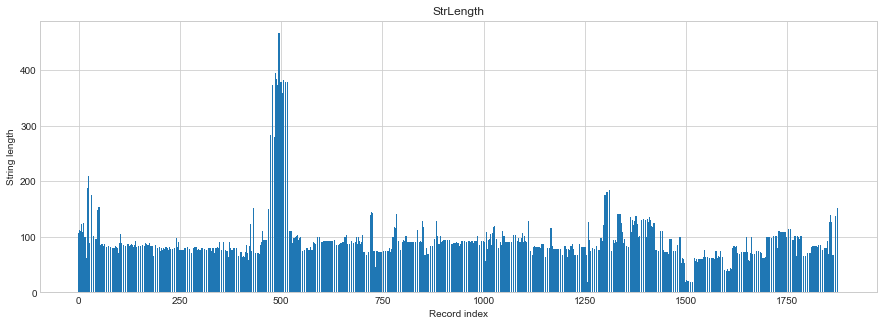

In [14]:
plt.figure(figsize=(15,5))
plt.bar(range(0,len(data_length),1),data_length)
plt.xlabel("Record index")
plt.ylabel("String length")
plt.title("StrLength")
plt.show()

## Jaccard VS Edit distance variance

In [15]:
from sklearn.decomposition import PCA 
from numpy.linalg import svd

def PCA_SpaceVisualization(X,title='PCA plot'):
    '''
    PCA to given array X and creating a plot
    Returns PCA components array after fit_transform
    '''
    
    # PCA code
    pca = PCA(n_components=2)
    pca.fit(X)
    pcaComponents = pca.fit_transform(X) # pcaComponents is the data that I'll use from PCA
    
    # Seperating components
    first_component = [x[0] for x in pcaComponents]
    second_component = [x[1] for x in pcaComponents]
    
    # Plotting code
    fig, ax = plt.subplots(figsize=(25,10))
    ax.scatter(first_component, second_component,alpha=0) 
    fig.suptitle(title,fontsize=40,fontweight='bold')
    ax.set_xlabel('X Component',fontsize=30,fontweight='bold')
    ax.set_ylabel('Y Component',fontsize=30,fontweight='bold')
    
    for x0, y0, i in zip(first_component, second_component,range(0,len(first_component),1)):
        plt.text(x0,y0,i, ha="center", va="center",fontsize=20,color='b')
        
    return pcaComponents


In [16]:
sent = 'This is an example of bigramms and trigramms!'
print(set(nltk.ngrams(sent, n=3)))
print(set(nltk.ngrams(nltk.word_tokenize(sent), n=3)))
print(nltk.jaccard_distance(set(nltk.ngrams(sent, n=3)),set(nltk.ngrams(sent, n=3))))
print(nltk.jaccard_distance(set(nltk.ngrams(nltk.word_tokenize(sent), n=3)),set(nltk.ngrams(nltk.word_tokenize(sent), n=3))))

{('s', ' ', 'i'), ('a', 'n', ' '), ('a', 'n', 'd'), ('m', 'p', 'l'), ('h', 'i', 's'), (' ', 'a', 'n'), ('r', 'i', 'g'), ('f', ' ', 'b'), ('s', ' ', 'a'), ('d', ' ', 't'), (' ', 'i', 's'), (' ', 'b', 'i'), ('a', 'm', 'm'), ('T', 'h', 'i'), ('e', ' ', 'o'), ('p', 'l', 'e'), ('i', 's', ' '), ('n', 'd', ' '), ('o', 'f', ' '), ('r', 'a', 'm'), ('n', ' ', 'e'), ('x', 'a', 'm'), (' ', 'o', 'f'), ('a', 'm', 'p'), ('g', 'r', 'a'), ('b', 'i', 'g'), ('l', 'e', ' '), (' ', 't', 'r'), ('m', 's', ' '), ('m', 's', '!'), (' ', 'e', 'x'), ('m', 'm', 's'), ('e', 'x', 'a'), ('i', 'g', 'r'), ('t', 'r', 'i')}
{('of', 'bigramms', 'and'), ('bigramms', 'and', 'trigramms'), ('and', 'trigramms', '!'), ('an', 'example', 'of'), ('example', 'of', 'bigramms'), ('This', 'is', 'an'), ('is', 'an', 'example')}
0.0
0.0


In [17]:
def myHeatmap(data,metric,distance):
    if metric == 'edit':    
        matrix  = np.zeros((len(data),len(data)), dtype=np.int)
    else:
        matrix = np.zeros((len(data),len(data)), dtype=np.float)
    
    for i in range(0,len(data),1):
        for j in range(0,len(data),1):
            if i != j:            
                matrix[i][j]  = distance(data[i],data[j])

                
    fif,ax = plt.subplots(1,figsize=(20,20))
    corr = np.corrcoef(matrix)
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    ax = sns.heatmap(matrix, linewidth=0.5,annot=False,cmap="Blues_r",mask=mask,fmt='.3g',ax=ax)
    plt.show()

### Evaluation

In [18]:
def similarityProbsHeatMap(similarityProb_matrix,clusters,title):
    fif,ax = plt.subplots(1,figsize=(20,20))
    colors = ['red','green','blue','yellow','orange']
    c=0
    for cl in clusters:
        for i  in range(0,len(cl)):
            for j in range(i+1,len(cl)):
                ax.add_patch(Rectangle((cl[j],cl[i]), 1, 1, fill=False, edgecolor=colors[c], lw=3))
        c+=1
#     corr = np.corrcoef(ed_matrix)
#     mask = np.zeros_like(corr)
#     mask[np.tril_indices_from(mask)] = True
    ax.set_title(title,fontsize=20,fontweight='bold')
    ax = sns.heatmap(similarityProb_matrix, linewidth=0.5,annot=True,cmap="Blues",fmt='.3g',ax=ax)
    plt.show()

In [19]:
s1 = "m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r.   andersson  nan j appl. phys."
s2 = "m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  j appl. phys. "

jc3 = jaccard_distance(set(nltk.ngrams(s1, n=3)),set(nltk.ngrams(s2, n=3)))
js3 = jaccard_distance(set(nltk.ngrams(nltk.word_tokenize(s1), n=3)),set(nltk.ngrams(nltk.word_tokenize(s2), n=3)))
jc2 = jaccard_distance(set(nltk.ngrams(s1, n=2)),set(nltk.ngrams(s2, n=2)))
js2 = jaccard_distance(set(nltk.ngrams(nltk.word_tokenize(s1), n=2)),set(nltk.ngrams(nltk.word_tokenize(s2), n=2)))

print(jc3,js3,jc2,js2)
print(editdistance.eval(s1,s2))

0.0784313725490196 0.22727272727272727 0.012987012987012988 0.13636363636363635
7


In [20]:
results_dataframe = pd.DataFrame(columns=['max_numberOf_clusters','max_editDistance','similarityThreshold','windowSize','metric','similarityVectors',"distanceMetricEmbedding","distanceMetric","number_of_permutations","ngramms","jaccard_with_chars",'Accuracy','Precision','Recall','F1','Time'])

In [ ]:
%%time

ngramms= 3                                  # If jaccard used, n-gramms are used
jaccard_withchars = True                    # n-gramms either of chars and either of words

# Prototype selection
max_numberOf_clusters= 500                  # Νumber of loops for finding representatives, it is an upper bound of clusters.
max_editDistance= 0.5                       # The threshold for the triangle inequality
distanceMetric= 'jaccard'                   # Distance metric between the vectors when creating the space

# Embedding phase
distanceMetricEmbedding = 'euclid_jaccard'  # Embedding metric

# WTA algorithm
windowSize= 100                             # Vector size for WTA algo
number_of_permutations = 30                 # WTA number of permutations


# Similarity evaluation
similarityVectors='ranked'                  # which vectors will be passed to WTA step
similarityThreshold= 0.7                    # Similarity threshold for the final step
metric='kendal'                             # Similarity metric between vectors




start = time.time()
model = RankedWTAHash(max_numberOf_clusters= max_numberOf_clusters,    max_editDistance= max_editDistance,    windowSize= windowSize,    similarityThreshold= similarityThreshold,    metric=metric,    similarityVectors=similarityVectors,    number_of_permutations = number_of_permutations,
distanceMetric= distanceMetric,distanceMetricEmbedding = distanceMetricEmbedding,ngramms= ngramms,jaccard_withchars = jaccard_withchars)
model = model.fit(data)
acc,f1,precision,recall = evaluate_cora(model.mapping_matrix,true_matrix, False)
exec_time = time.time() - start
results_dataframe.loc[len(results_dataframe)+1] = [max_numberOf_clusters,max_editDistance,similarityThreshold,windowSize,metric,similarityVectors,distanceMetricEmbedding,distanceMetric,number_of_permutations,ngramms,jaccard_withchars,acc,precision,recall,f1,exec_time]

In [ ]:
%%time
model = RankedWTAHash(
    max_numberOf_clusters= 30,
    max_editDistance= 0.6,
    windowSize= 5,
    similarityThreshold= 0.799,
    metric='kendal',
    similarityVectors='ranked',
    number_of_permutations = 5,
    distanceMetric= 'jaccard',
    distanceMetricEmbedding = 'l_inf',
    ngramms= 3,
    jaccard_withchars = False
)
model = model.fit(data)
evaluate_cora(model.mapping_matrix,true_matrix, False)
print(np.array(model.similarityProb_matrix))

## Grid search each section

### [i.] Fine tunning  __Prototype selection__


Goals:

- __Variance__: We want prototypes to be as much different as possible. This way, embeddings will be more characteristic.
- __Number__: We need a large amount of prototypes.

Parameters to fine tunne:

- ```max_numberOf_clusters```: Νumber of loops for finding representatives, it is an upper bound of clusters.
- ```max_editDistance```:  The threshold for the triangle inequality
- ```distanceMetric```:  Distance metric between the vectors when creating the space

All these parameters will be tested both for edit distance and jaccard with 3-grams.

-------------------------
max_numberOf_clusters:  10
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  True
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21]
Not wanted:
set()
Final:
[17, 21, 3, 13]

- Prototypes selected
[17 21  3 13]
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
13  ->  benford  s.  bowers  j.  fahlen  l.e.  greenhalgh  c.  snowdon  d. user embodiment in collaborative virtual environments. nan


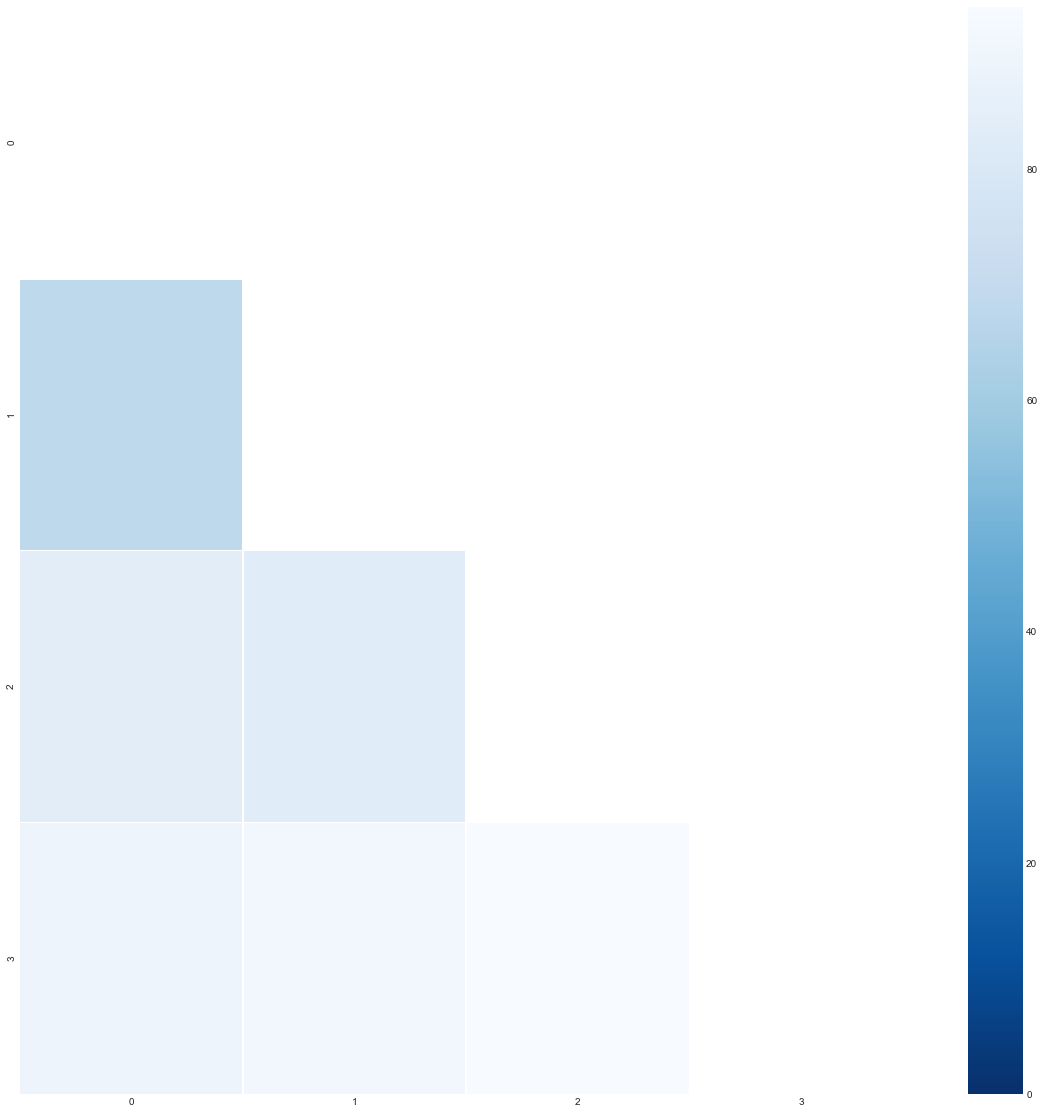


- Final number of prototypes:  4

# Finished in 0.6434 secs













-------------------------
max_numberOf_clusters:  10
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  True
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21]
Not wanted:
set()
Final:
[17, 3, 21, 9, 13]

- Prototypes selected
[17  3 21  9 13]
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
21  ->  b. buth et. al.  provably correct compiler implementation  nan
9  ->  steve benford and lennart e. fahlen. a spatial model of interaction in large virtual environments. nan
13  ->  benford  s.  bowers  j.  fahlen  l.e.  greenhalgh  c.  snowdon  d. user embodiment in collaborative virtual environments. nan


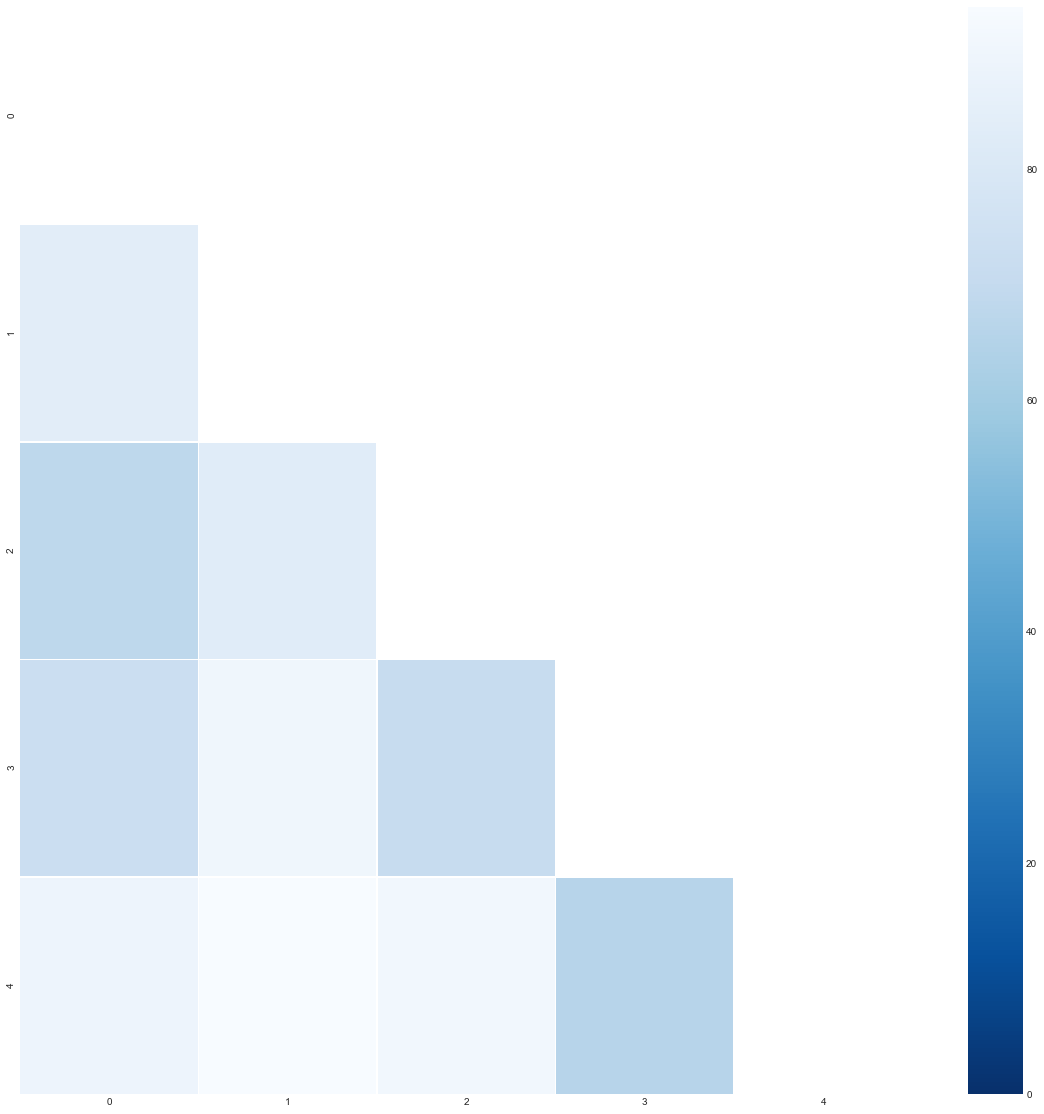


- Final number of prototypes:  5

# Finished in 0.5796 secs













-------------------------
max_numberOf_clusters:  10
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  True
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51]
Not wanted:
set()
Final:
[34, 3, 38, 46, 17, 51, 21, 24, 28, 30]

- Prototypes selected
[34  3 38 46 17 51 21 24 28 30]
34  ->  m. dill and m. ordereddict(('date'  '(1997b)')  ('#text'  'fahle  the role of visual field position in pattern-discrimination learning.')) nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
38  ->  fahle  m. w. and edelman  s. learning in hyperacuity: influence of stimulus range and of feedback. vision research.
46  ->  fahle  m. specificity of learning curvature  orientation  and vernier discriminations. vision research 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
51  ->  lennart e. fahlen  charles grant brown  olov stahl  and christer carlsson. a space based model for user interaction in shared synthetic environments. nan
21  ->  b. buth et. al.  provably corr

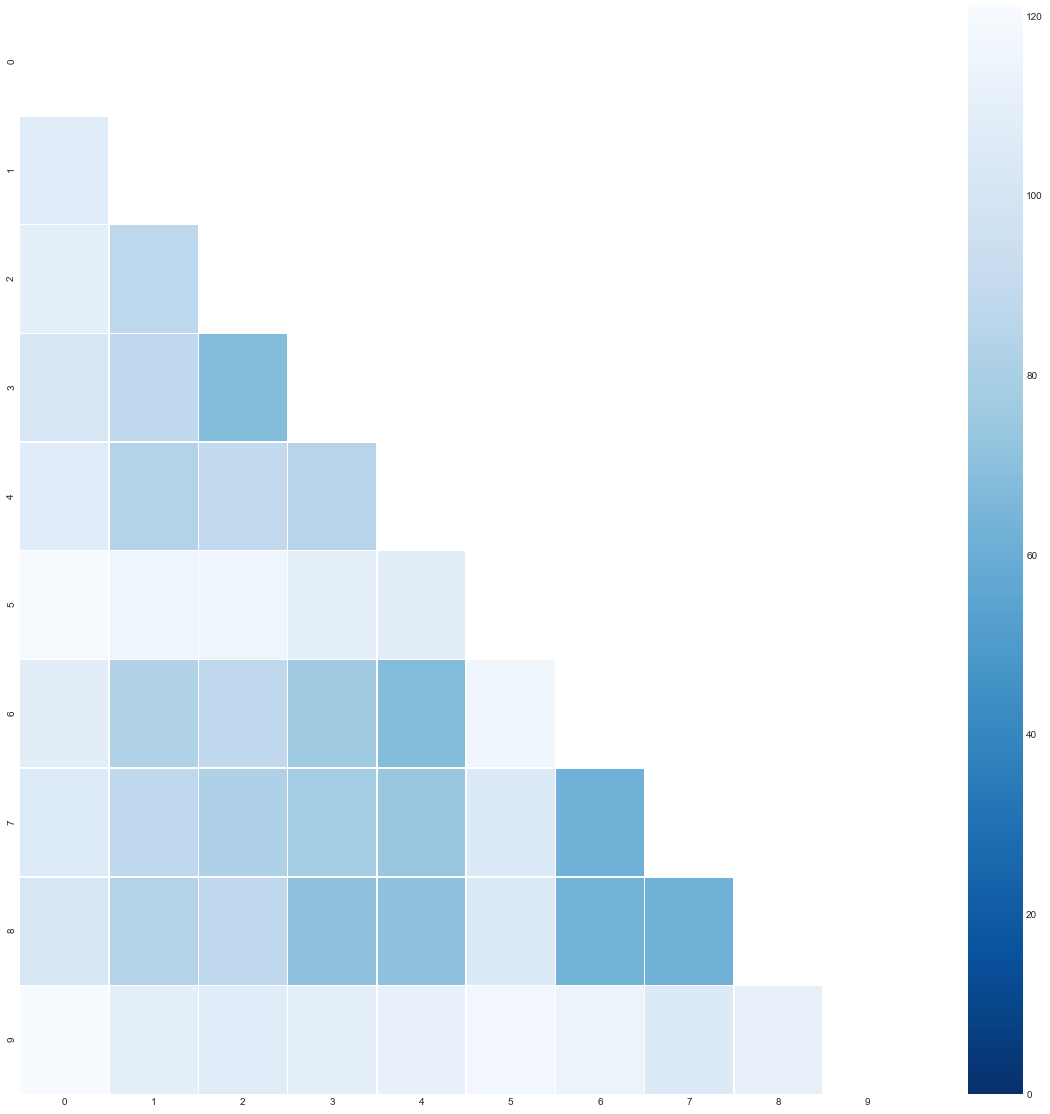


- Final number of prototypes:  10

# Finished in 0.7197 secs













-------------------------
max_numberOf_clusters:  10
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  True
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
set()
Final:
[482, 1653, 6, 472, 362, 476]

- Prototypes selected
[ 482 1653    6  472  362  476]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
1653  ->  utgoff  p. e. incremental induction of decision trees. machine learning 
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
472  ->  guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  and daniel l. weinreb. common lisp: the language. nan
362  ->  s. e. fahlman and c. lebiere. the cascade-correlation architecture. nan
476  ->  common lisp: the lan

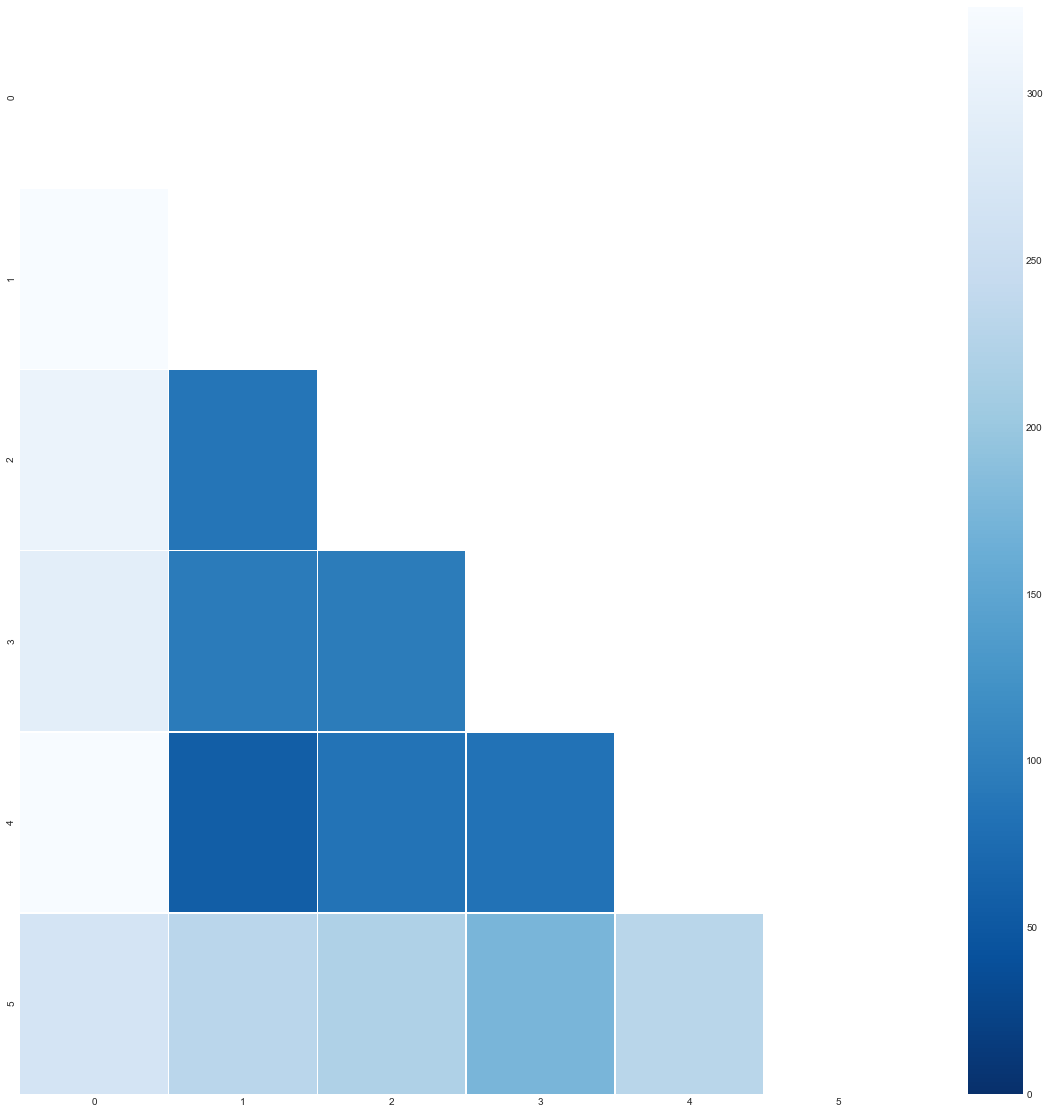


- Final number of prototypes:  6

# Finished in 0.7701 secs














-------------------------
max_numberOf_clusters:  50
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  True
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21, 28, 30, 32, 34, 39, 41, 44, 47, 51, 59, 65, 97, 100, 105, 107, 110, 136, 152, 160, 178, 190, 203, 244, 250, 284, 309, 384, 405, 415, 419]
Not wanted:
set()
Final:
[384, 3, 136, 13, 17, 21, 405, 152, 28, 284, 30, 415, 32, 160, 34, 419, 39, 41, 44, 47, 178, 51, 309, 59, 190, 65, 203, 97, 100, 105, 107, 110, 244, 250]

- Prototypes selected
[384   3 136  13  17  21 405 152  28 284  30 415  32 160  34 419  39  41
  44  47 178  51 309  59 190  65 203  97 100 105 107 110 244 250]
384  ->  s.e. fahlman and c. lebiere  the cascade-correlation learning architecture  nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
136  ->  s. fahlman. faster-learning variations on backpropagation: an empirical study. nan
13  ->  benford  s.  bowers  j.  fahlen  l.e.  greenhalgh  c.  snowdon  d. user embodiment in collaborative virtual environments. nan
17  ->  d. f. brown  h. moura  and d. a. watt. 

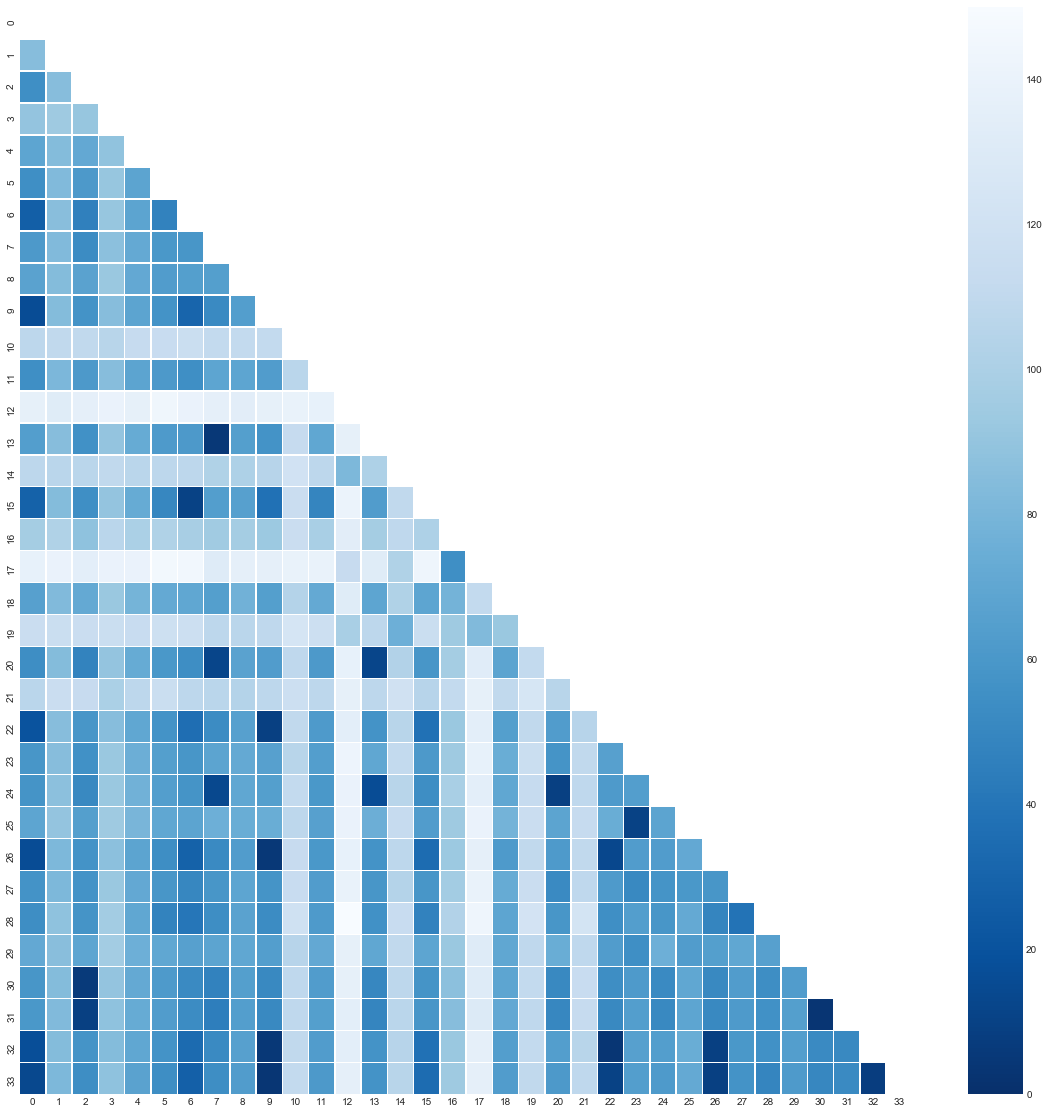


- Final number of prototypes:  34

# Finished in 1.3031 secs













-------------------------
max_numberOf_clusters:  50
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  True
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21, 28, 30, 32, 34, 36, 38, 40, 45, 47, 51, 60, 97, 100, 102, 105, 117, 180, 253, 415, 418, 424, 426, 428, 430, 432, 442, 451, 453, 456, 462, 467, 472, 477, 480, 482]
Not wanted:
set()
Final:
[3, 9, 13, 17, 21, 28, 30, 415, 32, 34, 418, 36, 38, 40, 424, 426, 428, 45, 430, 47, 432, 51, 180, 442, 60, 451, 453, 456, 462, 467, 472, 477, 480, 97, 482, 100, 102, 105, 117, 253]

- Prototypes selected
[  3   9  13  17  21  28  30 415  32  34 418  36  38  40 424 426 428  45
 430  47 432  51 180 442  60 451 453 456 462 467 472 477 480  97 482 100
 102 105 117 253]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
9  ->  steve benford and lennart e. fahlen. a spatial model of interaction in large virtual environments. nan
13  ->  benford  s.  bowers  j.  fahlen  l.e.  greenhalgh  c.  snowdon  d. user embodiment in collaborative virtual environments. nan
17  ->  d. f. brown  h. moura  and d.

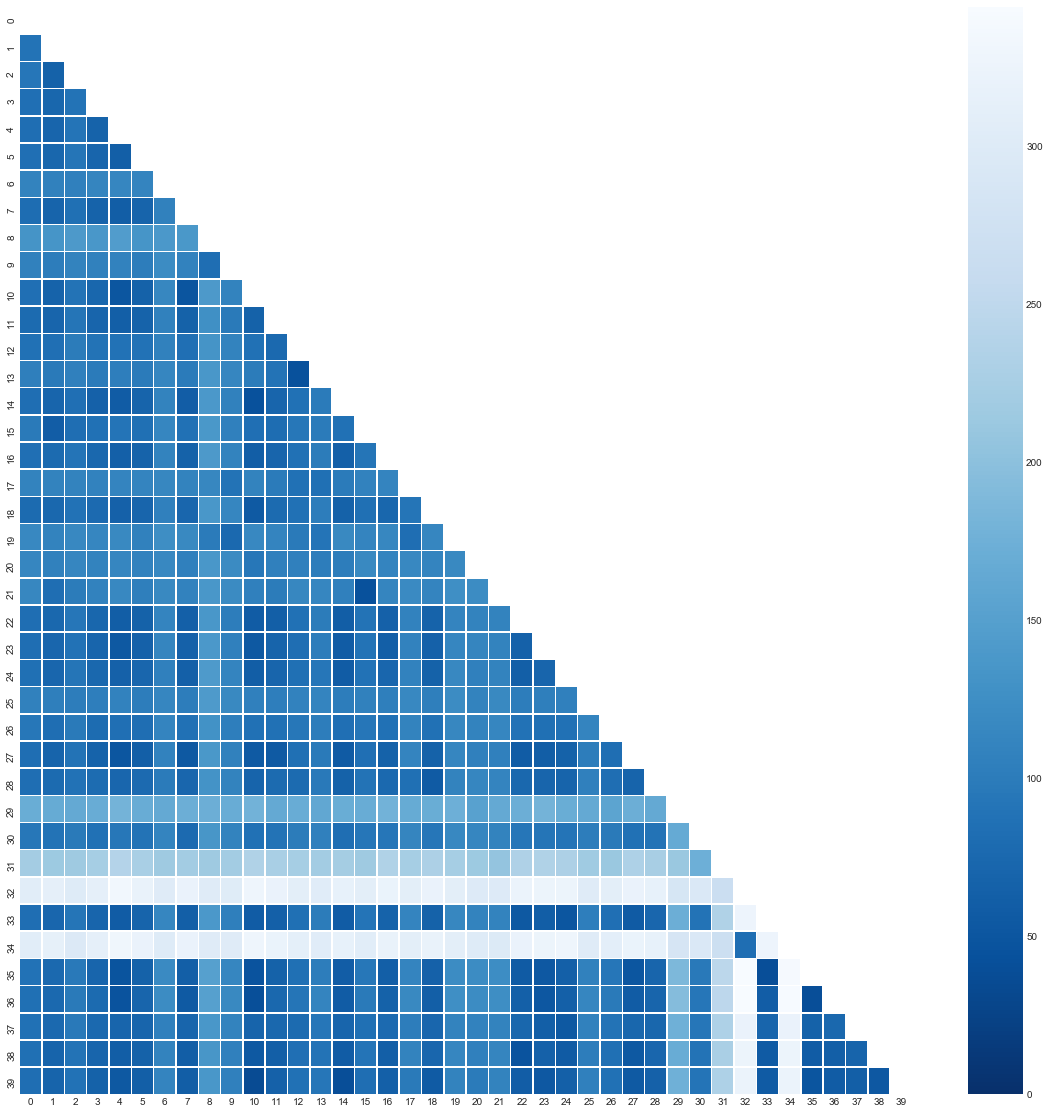


- Final number of prototypes:  40

# Finished in 1.4463 secs













-------------------------
max_numberOf_clusters:  50
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  True
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51, 243, 442, 452, 457, 467, 471, 476, 488, 496, 514, 640, 707, 718, 726, 751, 804, 1123, 1202, 1261, 1306, 1327, 1336, 1343, 1392, 1437, 1478, 1577, 1861, 1867, 1870, 1878]
Not wanted:
set()
Final:
[640, 514, 3, 17, 21, 24, 1306, 28, 1437, 30, 34, 804, 38, 1577, 46, 1327, 1202, 51, 1336, 442, 1343, 707, 452, 1861, 1478, 457, 1867, 718, 1870, 467, 726, 471, 1878, 476, 1123, 488, 1261, 751, 496, 1392, 243]

- Prototypes selected
[ 640  514    3   17   21   24 1306   28 1437   30   34  804   38 1577
   46 1327 1202   51 1336  442 1343  707  452 1861 1478  457 1867  718
 1870  467  726  471 1878  476 1123  488 1261  751  496 1392  243]
640  ->  aha  d.  kibler  d.  & albert  m. instance-based learning algorithms. machine learning
514  ->  s.b. thrun  j. bala  e. bloedorn  i. bratko  b. cestnik  j. cheng  k. de jong  s. dzeroski  s.e. fahlman  d. fisher  r. hamann  k. kaufman  s. keller  i. kononenko  j. kreuziger  r.s. michalsk

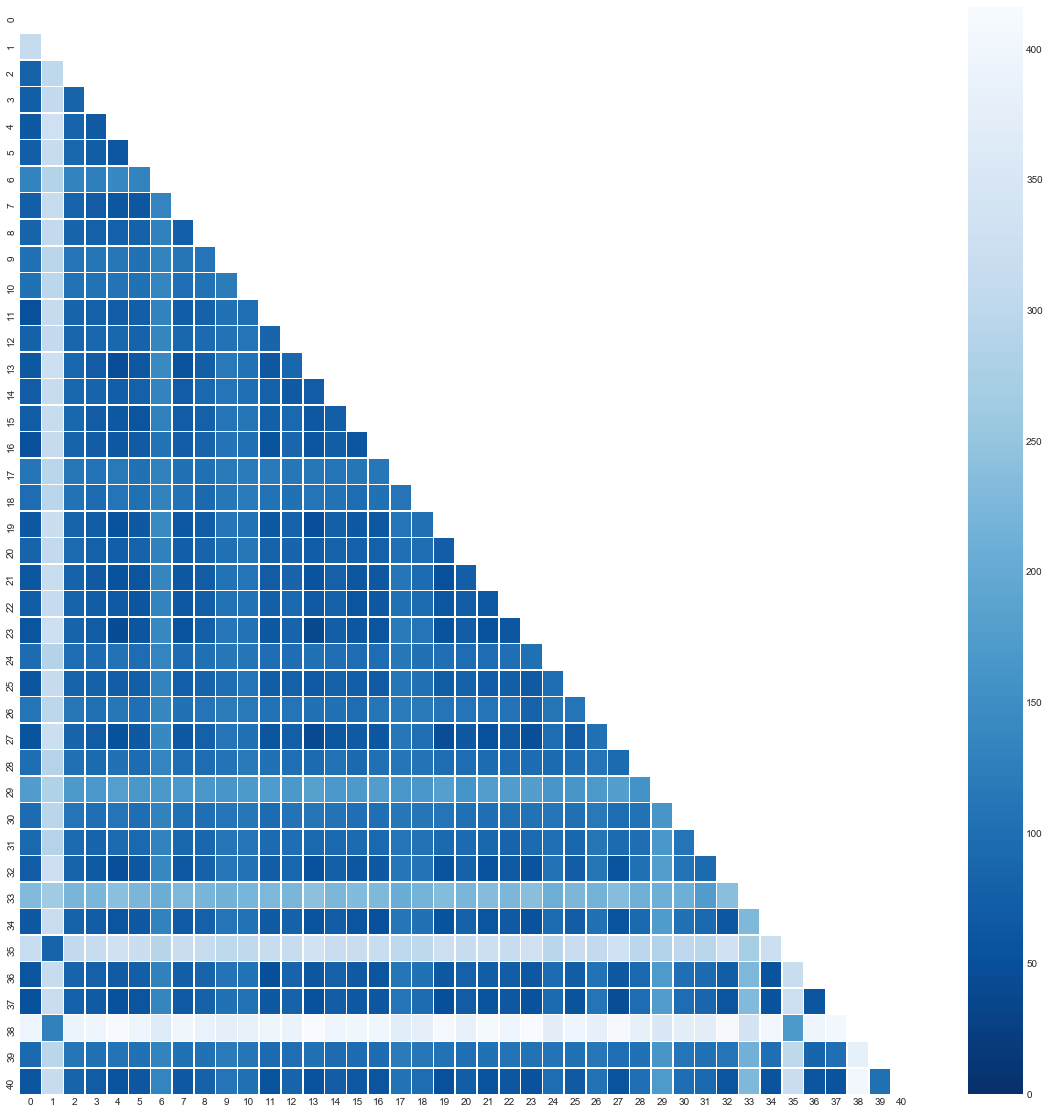


- Final number of prototypes:  41

# Finished in 1.7467 secs













-------------------------
max_numberOf_clusters:  50
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  True
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
set()
Final:
[482, 1653, 6, 472, 362, 476]

- Prototypes selected
[ 482 1653    6  472  362  476]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
1653  ->  utgoff  p. e. incremental induction of decision trees. machine learning 
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
472  ->  guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  and daniel l. weinreb. common lisp: the language. nan
362  ->  s. e. fahlman and c. lebiere. the cascade-correlation architecture. nan
476  ->  common lisp: the lan

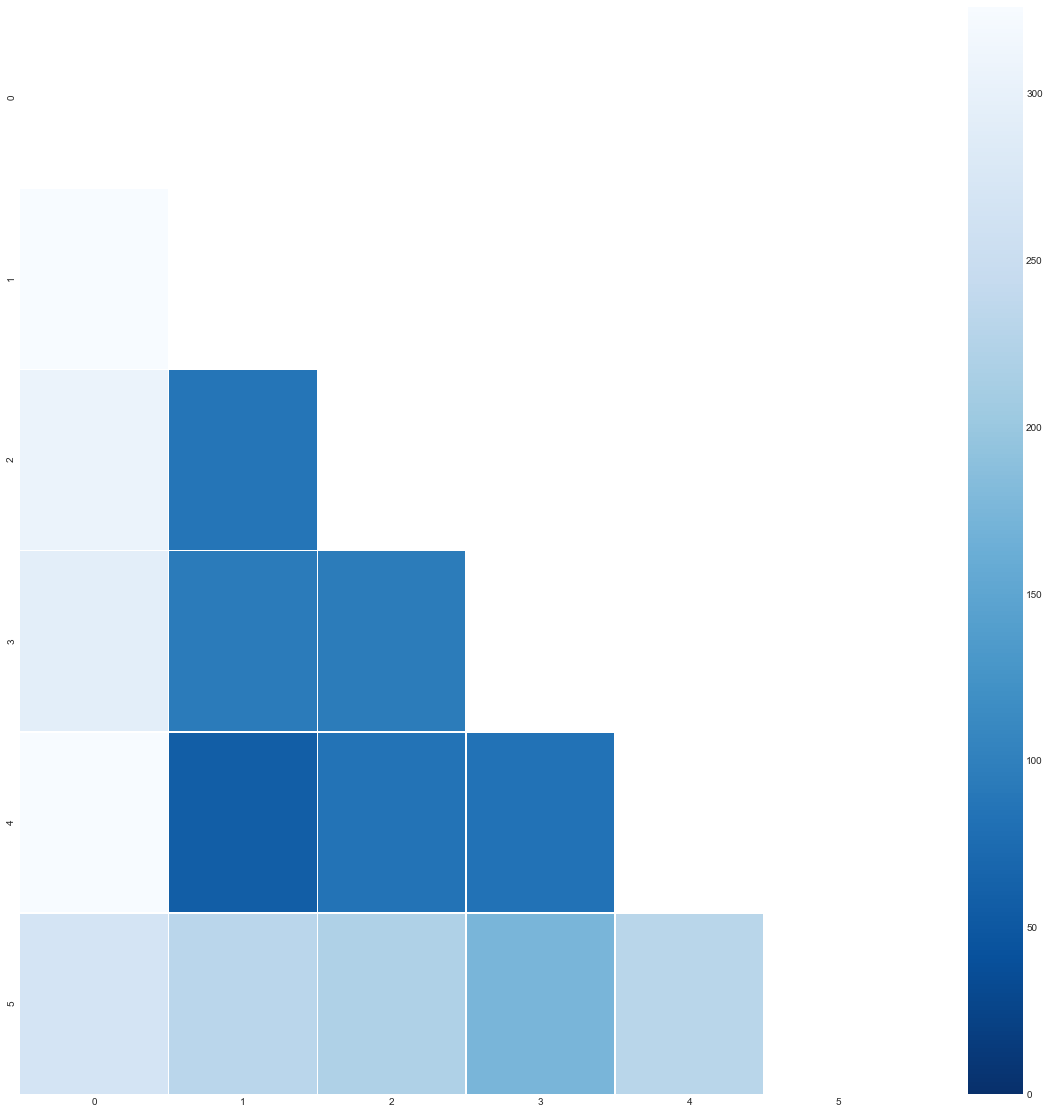


- Final number of prototypes:  6

# Finished in 0.7123 secs














-------------------------
max_numberOf_clusters:  100
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  True
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21, 28, 30, 32, 34, 39, 41, 44, 47, 51, 59, 65, 97, 100, 105, 107, 110, 136, 152, 160, 178, 190, 203, 244, 250, 284, 309, 384, 405, 415, 419, 424, 426, 442, 451, 453, 456, 462, 472, 477, 480, 482, 484, 486, 488, 492, 496, 501, 504, 507, 511, 515, 518, 525, 531, 562]
Not wanted:
{515}
Final:
[384, 3, 518, 136, 13, 525, 17, 531, 21, 405, 152, 28, 284, 30, 415, 32, 160, 34, 419, 39, 424, 41, 426, 44, 47, 178, 51, 562, 309, 442, 59, 190, 65, 451, 453, 456, 203, 462, 472, 477, 480, 97, 482, 100, 484, 486, 488, 105, 107, 492, 110, 496, 244, 501, 504, 250, 507, 511]

- Prototypes selected
[384   3 518 136  13 525  17 531  21 405 152  28 284  30 415  32 160  34
 419  39 424  41 426  44  47 178  51 562 309 442  59 190  65 451 453 456
 203 462 472 477 480  97 482 100 484 486 488 105 107 492 110 496 244 501
 504 250 507 511]
384  ->  s.e. fahlman and c. lebiere  the cascade-correlation learning architecture  nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dy

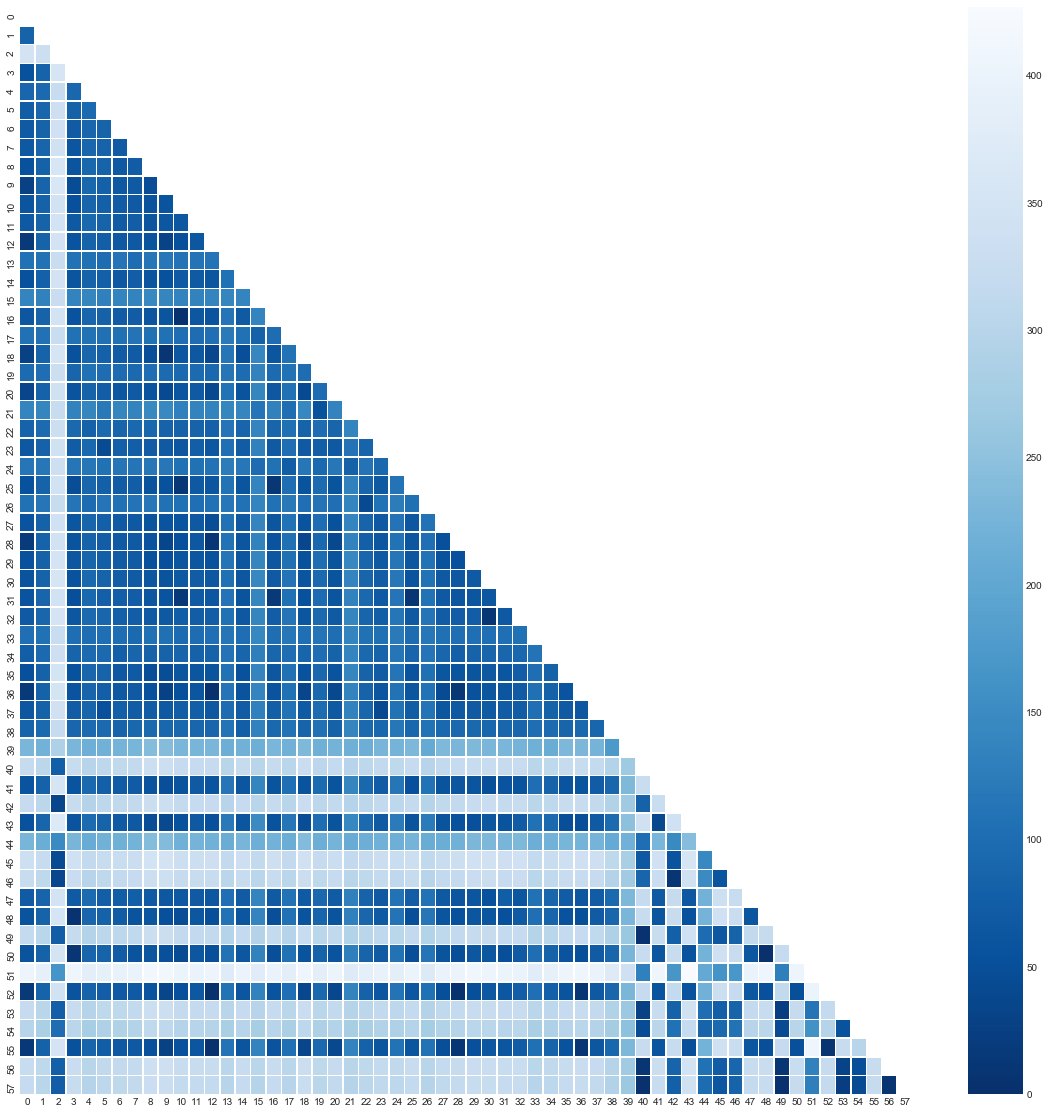


- Final number of prototypes:  58

# Finished in 2.9138 secs













-------------------------
max_numberOf_clusters:  100
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  True
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21, 28, 30, 32, 34, 36, 38, 40, 45, 47, 51, 60, 97, 100, 102, 105, 117, 180, 253, 415, 418, 424, 426, 428, 430, 432, 442, 451, 453, 456, 462, 467, 472, 477, 480, 482, 484, 488, 492, 496, 500, 503, 510, 514, 518, 520, 525, 528, 531, 603, 702, 708, 711, 713, 720, 725, 729, 731, 734, 745, 755, 774, 778, 783, 785, 788, 792, 821, 842, 852, 857, 867, 874, 883, 888, 948, 1006, 1009, 1011, 1013, 1015, 1017, 1021]
Not wanted:
{713, 514}
Final:
[3, 518, 774, 520, 9, 778, 13, 525, 783, 528, 17, 785, 531, 788, 21, 1021, 792, 28, 30, 32, 34, 36, 38, 40, 45, 47, 51, 821, 60, 842, 852, 857, 603, 97, 867, 100, 102, 105, 874, 883, 117, 888, 415, 418, 424, 426, 428, 430, 432, 180, 948, 442, 702, 451, 708, 453, 711, 456, 462, 720, 467, 725, 472, 729, 731, 477, 734, 480, 482, 503, 484, 488, 745, 492, 1006, 496, 1009, 755, 1011, 500, 1013, 1015, 1017, 253, 510]

- Prototypes selected
[   3  518  774  520    9  778   13  525  783  528   17  785  531  788
   21 1021  7

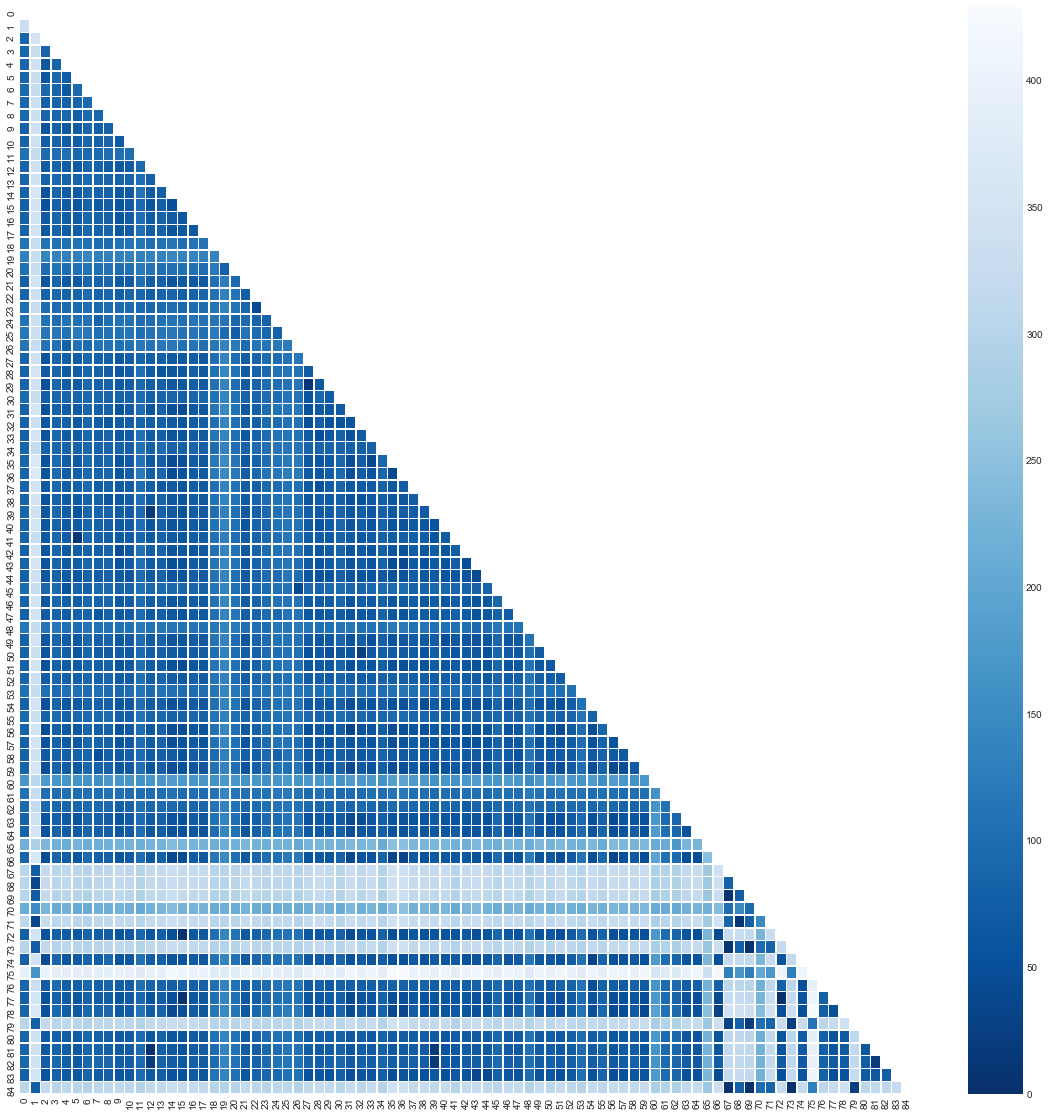


- Final number of prototypes:  85

# Finished in 4.3025 secs













-------------------------
max_numberOf_clusters:  100
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  True
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51, 243, 442, 452, 457, 467, 471, 476, 488, 496, 514, 640, 707, 718, 726, 751, 804, 1123, 1202, 1261, 1306, 1327, 1336, 1343, 1392, 1437, 1478, 1577, 1861, 1867, 1870, 1878]
Not wanted:
set()
Final:
[640, 514, 3, 17, 21, 24, 1306, 28, 1437, 30, 34, 804, 38, 1577, 46, 1327, 1202, 51, 1336, 442, 1343, 707, 452, 1861, 1478, 457, 1867, 718, 1870, 467, 726, 471, 1878, 476, 1123, 488, 1261, 751, 496, 1392, 243]

- Prototypes selected
[ 640  514    3   17   21   24 1306   28 1437   30   34  804   38 1577
   46 1327 1202   51 1336  442 1343  707  452 1861 1478  457 1867  718
 1870  467  726  471 1878  476 1123  488 1261  751  496 1392  243]
640  ->  aha  d.  kibler  d.  & albert  m. instance-based learning algorithms. machine learning
514  ->  s.b. thrun  j. bala  e. bloedorn  i. bratko  b. cestnik  j. cheng  k. de jong  s. dzeroski  s.e. fahlman  d. fisher  r. hamann  k. kaufman  s. keller  i. kononenko  j. kreuziger  r.s. michalsk

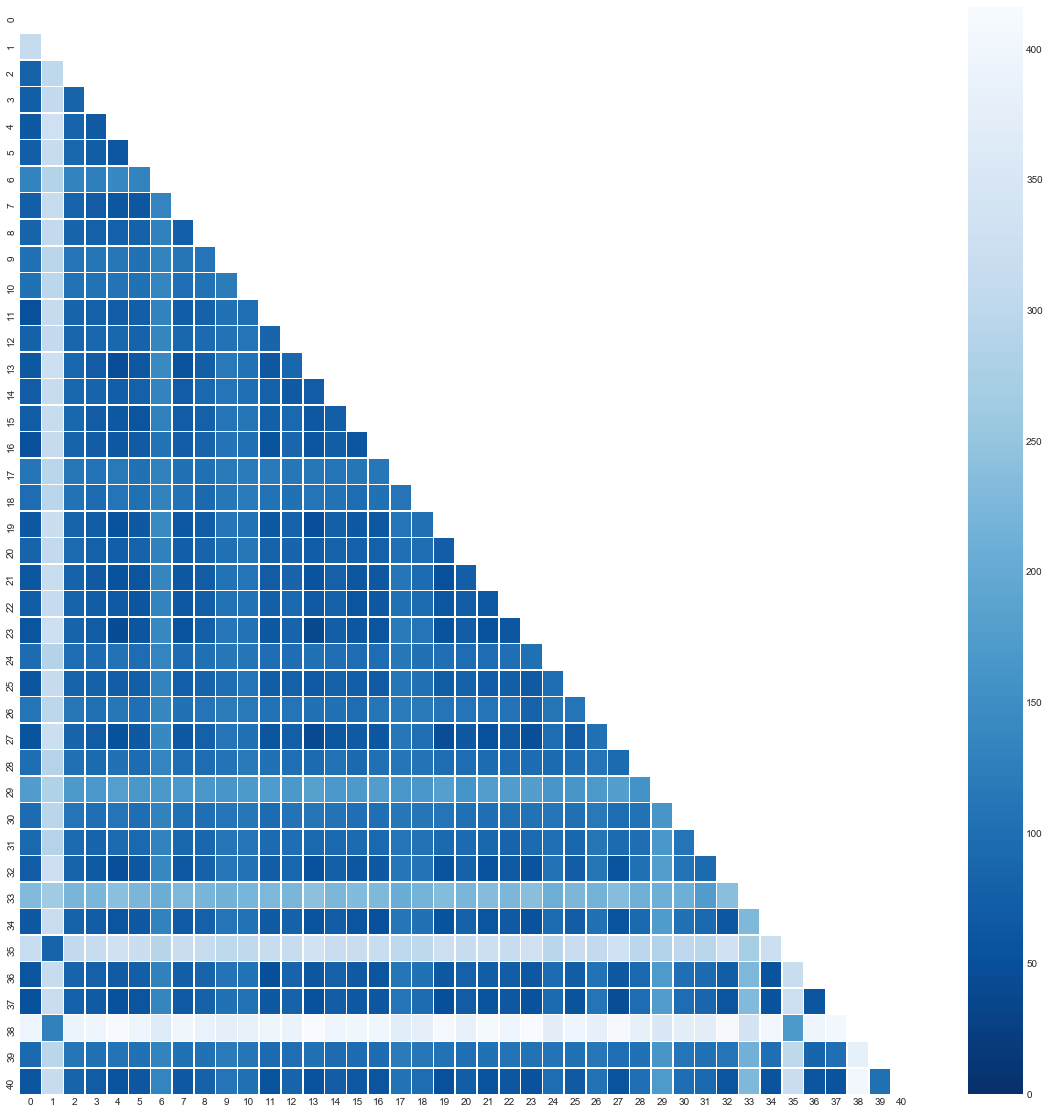


- Final number of prototypes:  41

# Finished in 2.0075 secs













-------------------------
max_numberOf_clusters:  100
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  True
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
set()
Final:
[482, 1653, 6, 472, 362, 476]

- Prototypes selected
[ 482 1653    6  472  362  476]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
1653  ->  utgoff  p. e. incremental induction of decision trees. machine learning 
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
472  ->  guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  and daniel l. weinreb. common lisp: the language. nan
362  ->  s. e. fahlman and c. lebiere. the cascade-correlation architecture. nan
476  ->  common lisp: the lan

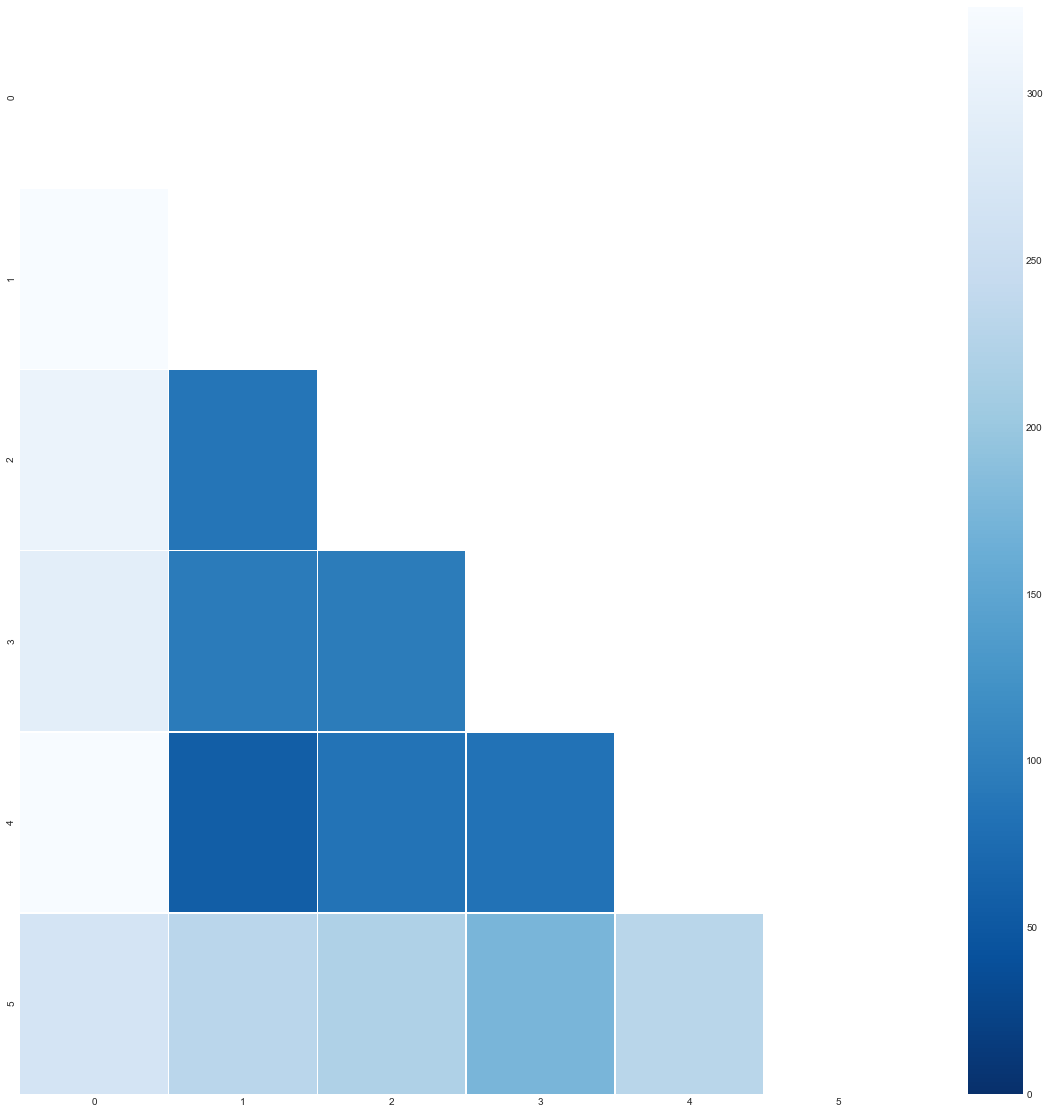


- Final number of prototypes:  6

# Finished in 1.0593 secs














-------------------------
max_numberOf_clusters:  500
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  True
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21, 28, 30, 32, 34, 39, 41, 44, 47, 51, 59, 65, 97, 100, 105, 107, 110, 136, 152, 160, 178, 190, 203, 244, 250, 284, 309, 384, 405, 415, 419, 424, 426, 442, 451, 453, 456, 462, 472, 477, 480, 482, 484, 486, 488, 492, 496, 501, 504, 507, 511, 515, 518, 525, 531, 562, 631, 664, 668, 700, 702, 707, 711, 719, 725, 729, 731, 734, 744, 758, 771, 774, 778, 783, 788, 792, 796, 800, 822, 838, 845, 852, 857, 860, 864, 874, 882, 888, 948, 1006, 1013, 1017, 1021, 1027, 1032, 1036, 1039, 1044, 1048, 1059, 1085, 1101, 1114, 1119, 1121, 1139, 1158, 1163, 1166, 1170, 1180, 1200, 1209, 1219, 1223, 1230, 1244, 1254, 1257, 1268, 1283, 1292, 1296, 1298, 1301, 1309, 1319, 1327, 1335, 1340, 1344, 1348, 1352, 1357, 1362, 1364, 1374, 1379, 1385, 1389, 1393, 1397, 1401, 1403, 1408, 1412, 1416, 1421, 1429, 1440, 1450, 1464, 1473, 1480, 1483, 1487, 1495, 1500, 1512, 1531, 1557, 1579, 1590, 1604, 1619, 1626, 1646, 1657, 1663, 1677, 1694, 1712, 1732, 1768, 1774, 1779, 1798, 182

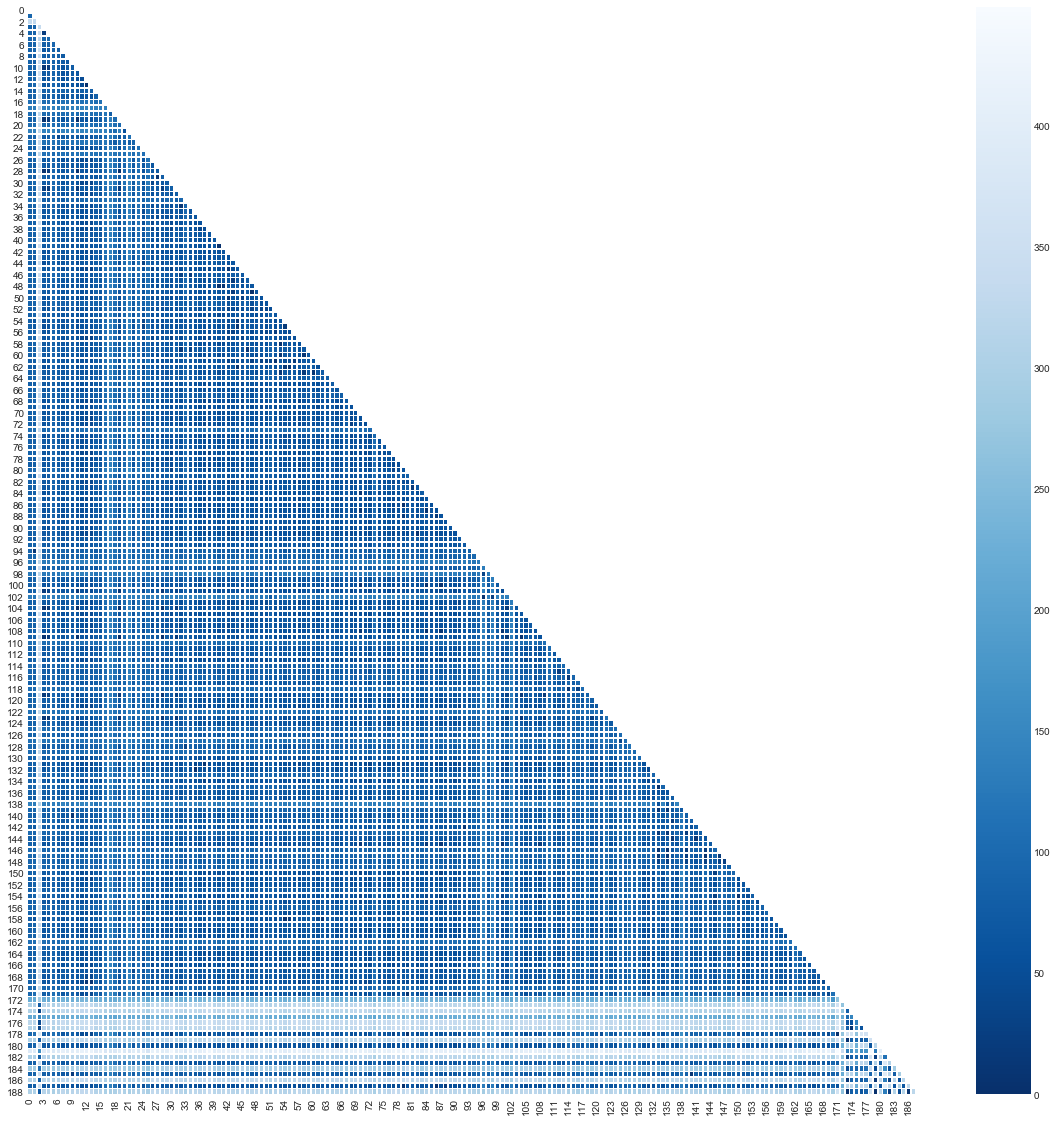


- Final number of prototypes:  189

# Finished in 4.9622 secs













-------------------------
max_numberOf_clusters:  500
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  True
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21, 28, 30, 32, 34, 36, 38, 40, 45, 47, 51, 60, 97, 100, 102, 105, 117, 180, 253, 415, 418, 424, 426, 428, 430, 432, 442, 451, 453, 456, 462, 467, 472, 477, 480, 482, 484, 488, 492, 496, 500, 503, 510, 514, 518, 520, 525, 528, 531, 603, 702, 708, 711, 713, 720, 725, 729, 731, 734, 745, 755, 774, 778, 783, 785, 788, 792, 821, 842, 852, 857, 867, 874, 883, 888, 948, 1006, 1009, 1011, 1013, 1015, 1017, 1021, 1027, 1034, 1039, 1044, 1048, 1093, 1114, 1120, 1134, 1148, 1166, 1168, 1192, 1218, 1231, 1244, 1256, 1259, 1268, 1283, 1292, 1296, 1306, 1320, 1327, 1335, 1343, 1348, 1352, 1357, 1362, 1364, 1368, 1373, 1385, 1391, 1395, 1397, 1401, 1403, 1409, 1416, 1421, 1429, 1440, 1450, 1464, 1473, 1480, 1483, 1487, 1489, 1542, 1598, 1621, 1646, 1683, 1694, 1712, 1739, 1756, 1768, 1774, 1779, 1816, 1848, 1851, 1853, 1859, 1864, 1867, 1870, 1878]
Not wanted:
{713, 514, 1409}
Final:
[3, 1027, 518, 1542, 520, 9, 1034, 13, 525, 1039, 528, 17, 531, 1044, 21, 104

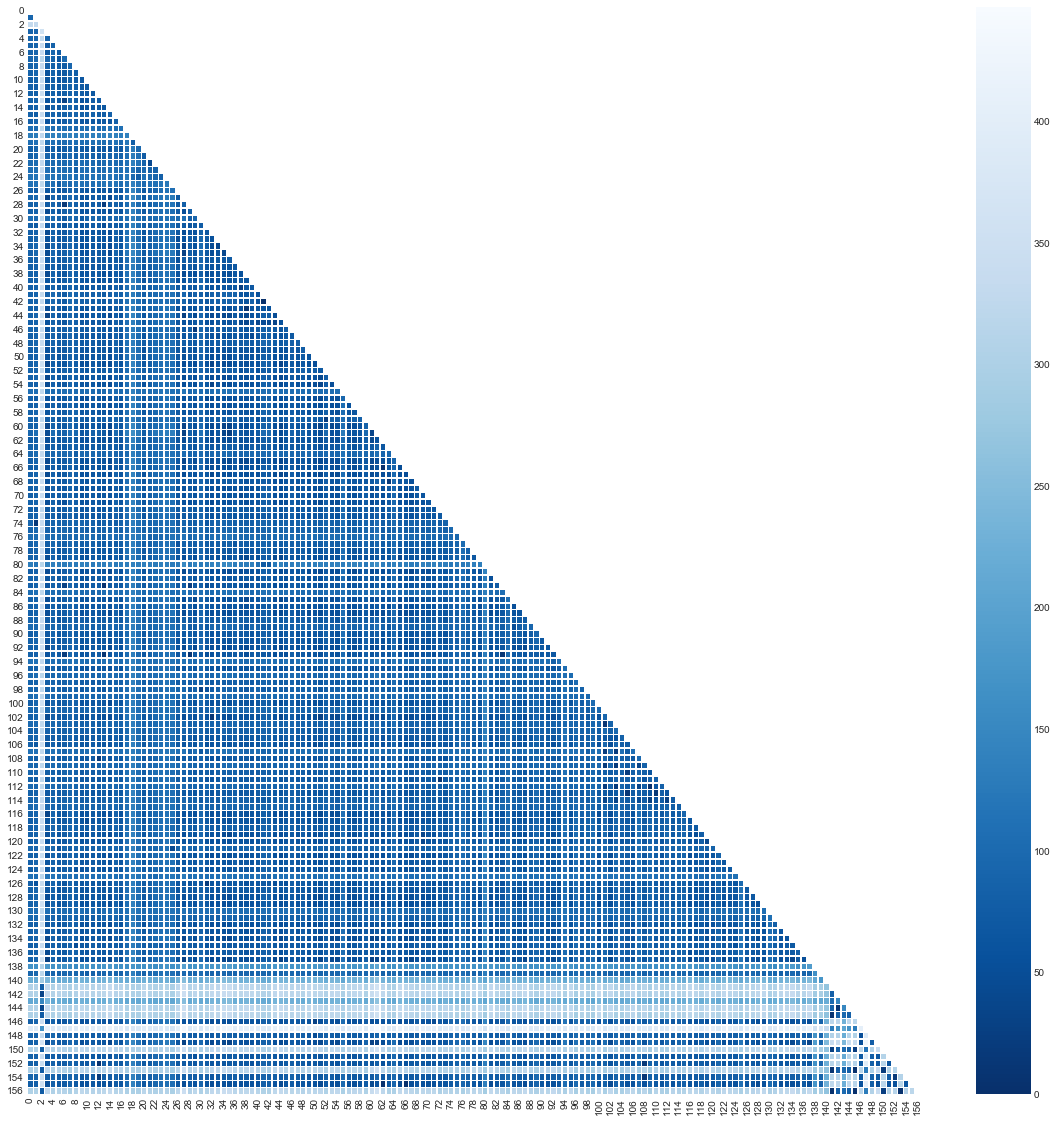


- Final number of prototypes:  157

# Finished in 4.1255 secs













-------------------------
max_numberOf_clusters:  500
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  True
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51, 243, 442, 452, 457, 467, 471, 476, 488, 496, 514, 640, 707, 718, 726, 751, 804, 1123, 1202, 1261, 1306, 1327, 1336, 1343, 1392, 1437, 1478, 1577, 1861, 1867, 1870, 1878]
Not wanted:
set()
Final:
[640, 514, 3, 17, 21, 24, 1306, 28, 1437, 30, 34, 804, 38, 1577, 46, 1327, 1202, 51, 1336, 442, 1343, 707, 452, 1861, 1478, 457, 1867, 718, 1870, 467, 726, 471, 1878, 476, 1123, 488, 1261, 751, 496, 1392, 243]

- Prototypes selected
[ 640  514    3   17   21   24 1306   28 1437   30   34  804   38 1577
   46 1327 1202   51 1336  442 1343  707  452 1861 1478  457 1867  718
 1870  467  726  471 1878  476 1123  488 1261  751  496 1392  243]
640  ->  aha  d.  kibler  d.  & albert  m. instance-based learning algorithms. machine learning
514  ->  s.b. thrun  j. bala  e. bloedorn  i. bratko  b. cestnik  j. cheng  k. de jong  s. dzeroski  s.e. fahlman  d. fisher  r. hamann  k. kaufman  s. keller  i. kononenko  j. kreuziger  r.s. michalsk

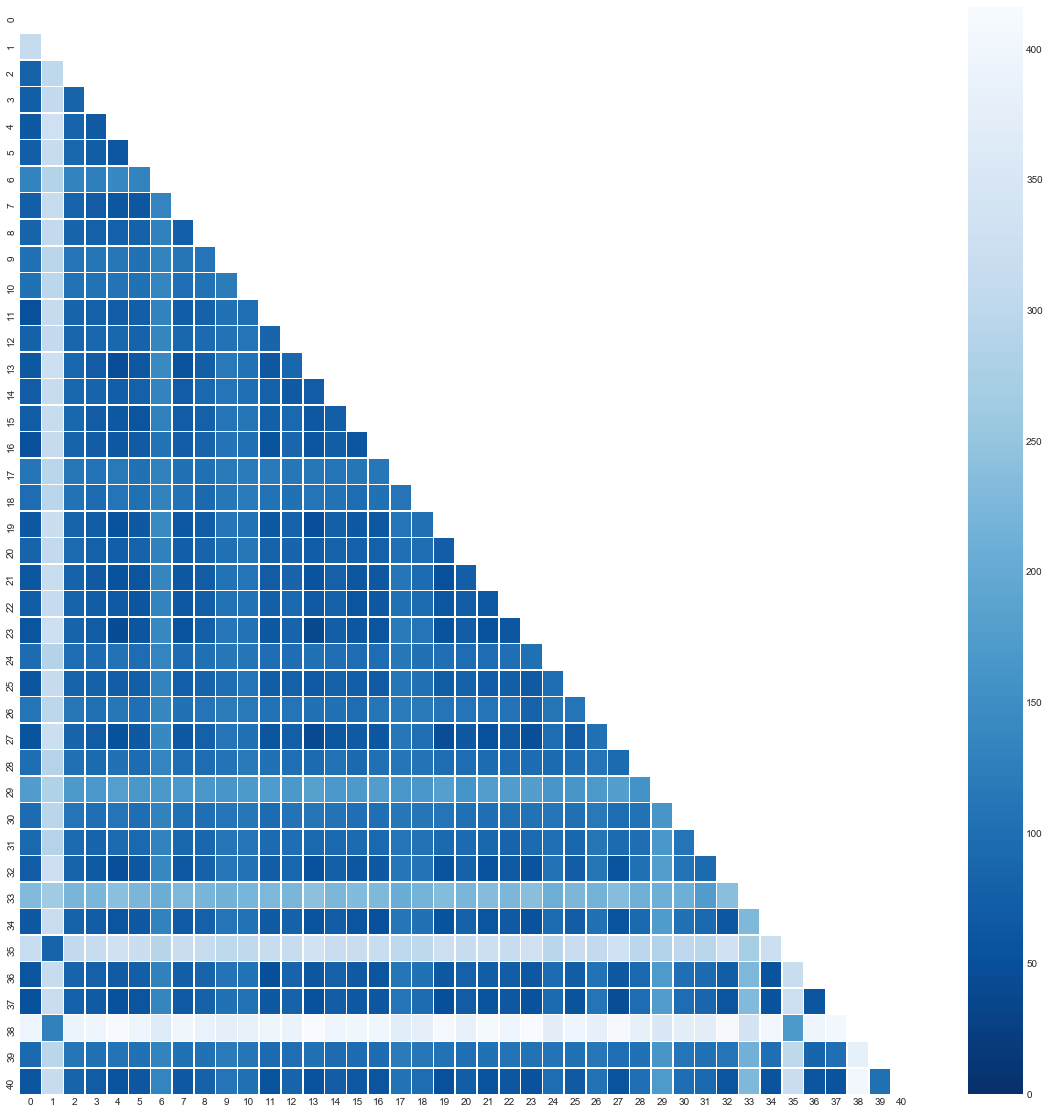


- Final number of prototypes:  41

# Finished in 1.5200 secs













-------------------------
max_numberOf_clusters:  500
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  True
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
set()
Final:
[482, 1653, 6, 472, 362, 476]

- Prototypes selected
[ 482 1653    6  472  362  476]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
1653  ->  utgoff  p. e. incremental induction of decision trees. machine learning 
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
472  ->  guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  and daniel l. weinreb. common lisp: the language. nan
362  ->  s. e. fahlman and c. lebiere. the cascade-correlation architecture. nan
476  ->  common lisp: the lan

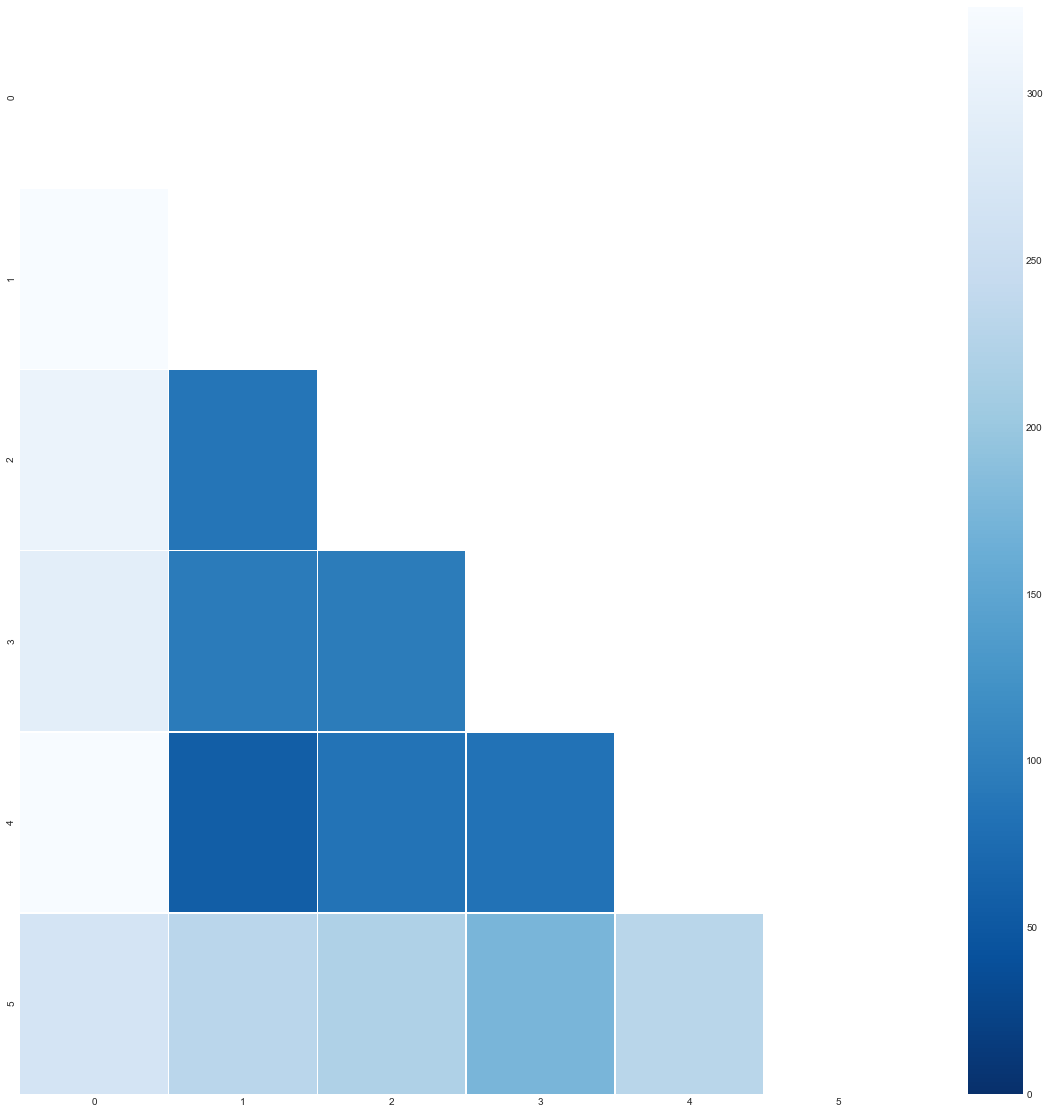


- Final number of prototypes:  6

# Finished in 0.7708 secs














-------------------------
max_numberOf_clusters:  1000
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  True
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21, 28, 30, 32, 34, 39, 41, 44, 47, 51, 59, 65, 97, 100, 105, 107, 110, 136, 152, 160, 178, 190, 203, 244, 250, 284, 309, 384, 405, 415, 419, 424, 426, 442, 451, 453, 456, 462, 472, 477, 480, 482, 484, 486, 488, 492, 496, 501, 504, 507, 511, 515, 518, 525, 531, 562, 631, 664, 668, 700, 702, 707, 711, 719, 725, 729, 731, 734, 744, 758, 771, 774, 778, 783, 788, 792, 796, 800, 822, 838, 845, 852, 857, 860, 864, 874, 882, 888, 948, 1006, 1013, 1017, 1021, 1027, 1032, 1036, 1039, 1044, 1048, 1059, 1085, 1101, 1114, 1119, 1121, 1139, 1158, 1163, 1166, 1170, 1180, 1200, 1209, 1219, 1223, 1230, 1244, 1254, 1257, 1268, 1283, 1292, 1296, 1298, 1301, 1309, 1319, 1327, 1335, 1340, 1344, 1348, 1352, 1357, 1362, 1364, 1374, 1379, 1385, 1389, 1393, 1397, 1401, 1403, 1408, 1412, 1416, 1421, 1429, 1440, 1450, 1464, 1473, 1480, 1483, 1487, 1495, 1500, 1512, 1531, 1557, 1579, 1590, 1604, 1619, 1626, 1646, 1657, 1663, 1677, 1694, 1712, 1732, 1768, 1774, 1779, 1798, 182

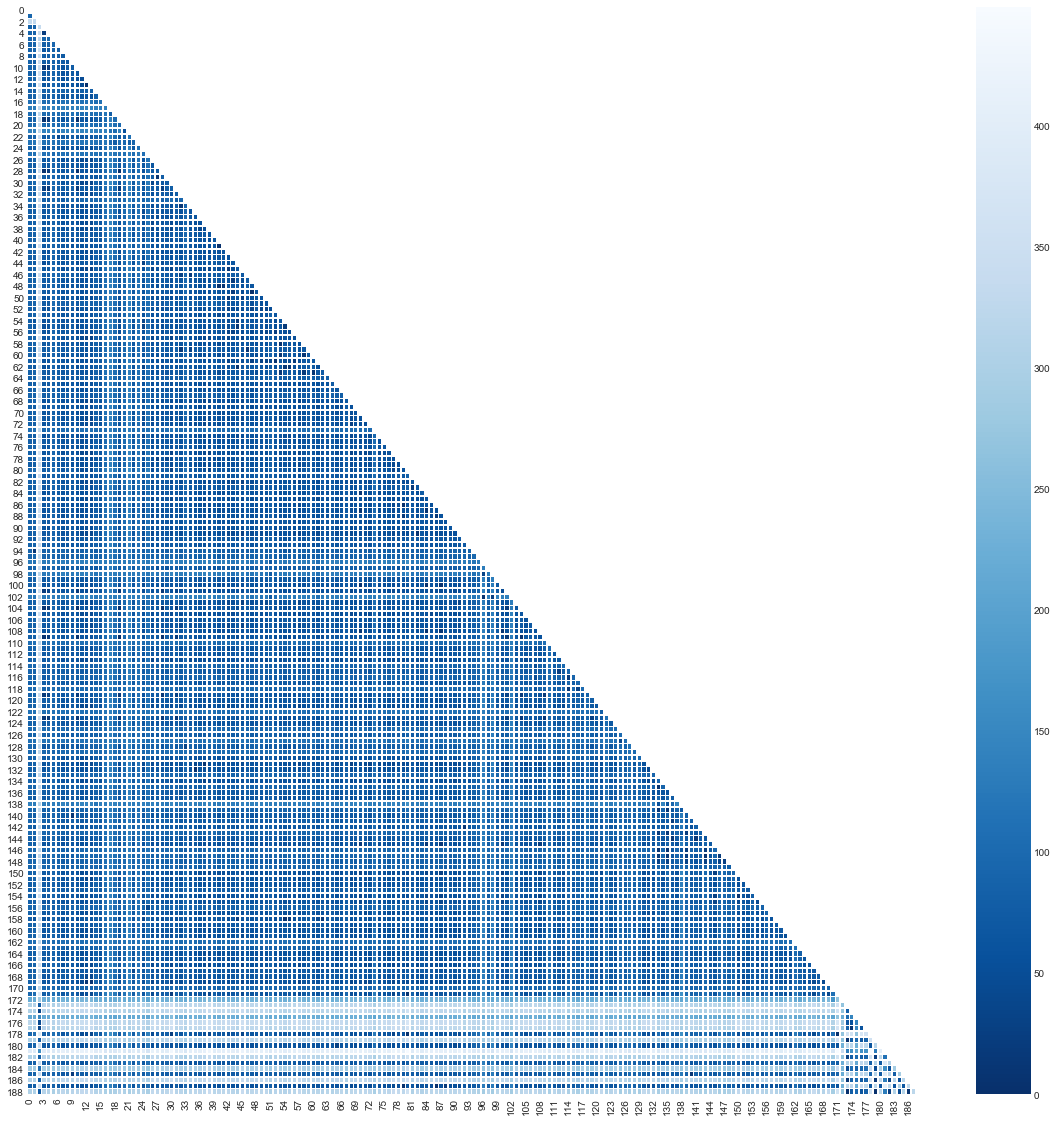


- Final number of prototypes:  189

# Finished in 4.5151 secs













-------------------------
max_numberOf_clusters:  1000
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  True
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21, 28, 30, 32, 34, 36, 38, 40, 45, 47, 51, 60, 97, 100, 102, 105, 117, 180, 253, 415, 418, 424, 426, 428, 430, 432, 442, 451, 453, 456, 462, 467, 472, 477, 480, 482, 484, 488, 492, 496, 500, 503, 510, 514, 518, 520, 525, 528, 531, 603, 702, 708, 711, 713, 720, 725, 729, 731, 734, 745, 755, 774, 778, 783, 785, 788, 792, 821, 842, 852, 857, 867, 874, 883, 888, 948, 1006, 1009, 1011, 1013, 1015, 1017, 1021, 1027, 1034, 1039, 1044, 1048, 1093, 1114, 1120, 1134, 1148, 1166, 1168, 1192, 1218, 1231, 1244, 1256, 1259, 1268, 1283, 1292, 1296, 1306, 1320, 1327, 1335, 1343, 1348, 1352, 1357, 1362, 1364, 1368, 1373, 1385, 1391, 1395, 1397, 1401, 1403, 1409, 1416, 1421, 1429, 1440, 1450, 1464, 1473, 1480, 1483, 1487, 1489, 1542, 1598, 1621, 1646, 1683, 1694, 1712, 1739, 1756, 1768, 1774, 1779, 1816, 1848, 1851, 1853, 1859, 1864, 1867, 1870, 1878]
Not wanted:
{713, 514, 1409}
Final:
[3, 1027, 518, 1542, 520, 9, 1034, 13, 525, 1039, 528, 17, 531, 1044, 21, 104

731  ->  kelly  j. d. & davis  l. a hybrid genetic algorithm for classification. nan
1244  ->  r. caruana. multitask learning: a knowledge-based of source of inductive bias. nan
1756  ->  paul e. utgoff and carla e. brodley. an incremental method for finding multivariate splits for decision trees. nan
734  ->  kibler  d.  & porter  b. episodic learning. nan
1256  ->  chapman  d. nan nan
745  ->  kibler  d. & langley  p. machine learning as an experimental science. nan
1768  ->  utgoff  p. e.  & clouse  j. a. two kinds of training information for evaluation function learning. nan
1259  ->  cleeremans  a.  servan-schreiber  d.  & mcclelland  j. finite state automata and simple recurrent networks. neural computation 
1774  ->  utgoff  p.e. and brodley  c.e. linear machine decision trees. nan
755  ->  kibler  d.  & langley  p. machine learning as an experimental science. nan
1268  ->  j. clouse and p. utgoff. a teaching method for reinforcement learning. nan
1779  ->  p.e. utgoff and j.a. 

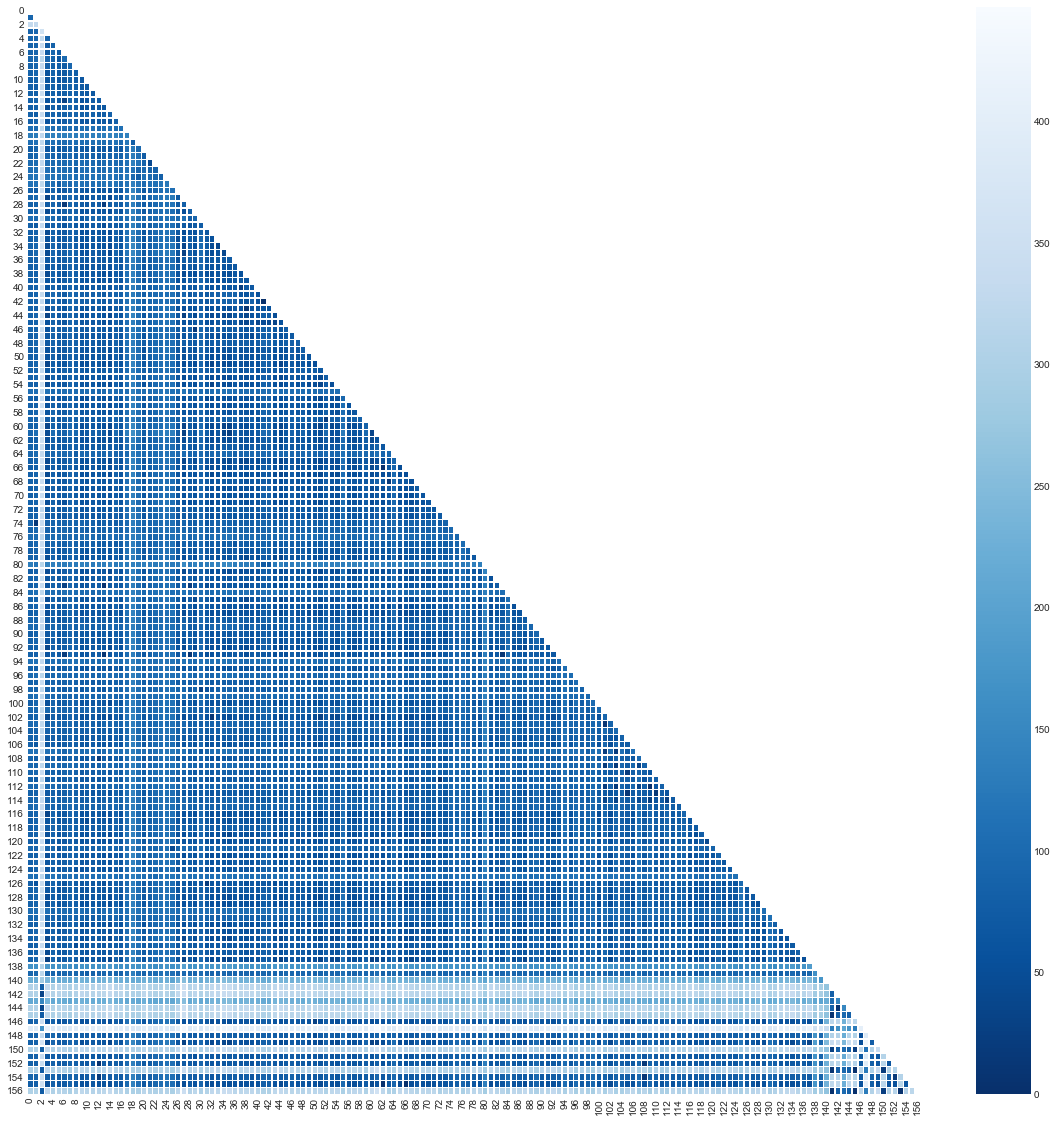


- Final number of prototypes:  157

# Finished in 3.8591 secs













-------------------------
max_numberOf_clusters:  1000
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  True
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51, 243, 442, 452, 457, 467, 471, 476, 488, 496, 514, 640, 707, 718, 726, 751, 804, 1123, 1202, 1261, 1306, 1327, 1336, 1343, 1392, 1437, 1478, 1577, 1861, 1867, 1870, 1878]
Not wanted:
set()
Final:
[640, 514, 3, 17, 21, 24, 1306, 28, 1437, 30, 34, 804, 38, 1577, 46, 1327, 1202, 51, 1336, 442, 1343, 707, 452, 1861, 1478, 457, 1867, 718, 1870, 467, 726, 471, 1878, 476, 1123, 488, 1261, 751, 496, 1392, 243]

- Prototypes selected
[ 640  514    3   17   21   24 1306   28 1437   30   34  804   38 1577
   46 1327 1202   51 1336  442 1343  707  452 1861 1478  457 1867  718
 1870  467  726  471 1878  476 1123  488 1261  751  496 1392  243]
640  ->  aha  d.  kibler  d.  & albert  m. instance-based learning algorithms. machine learning
514  ->  s.b. thrun  j. bala  e. bloedorn  i. bratko  b. cestnik  j. cheng  k. de jong  s. dzeroski  s.e. fahlman  d. fisher  r. hamann  k. kaufman  s. keller  i. kononenko  j. kreuziger  r.s. michalsk

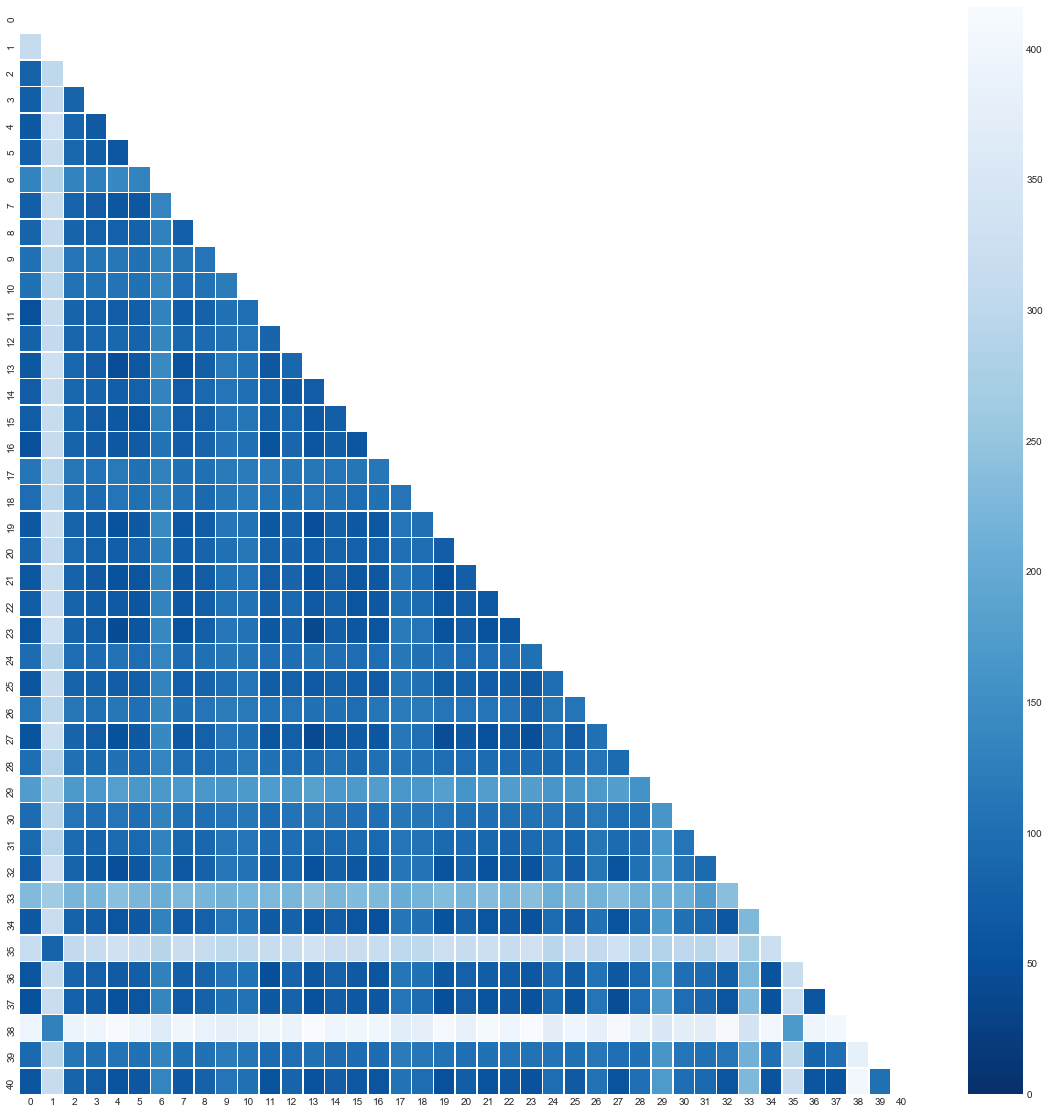


- Final number of prototypes:  41

# Finished in 1.4176 secs













-------------------------
max_numberOf_clusters:  1000
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  True
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
set()
Final:
[482, 1653, 6, 472, 362, 476]

- Prototypes selected
[ 482 1653    6  472  362  476]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
1653  ->  utgoff  p. e. incremental induction of decision trees. machine learning 
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
472  ->  guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  and daniel l. weinreb. common lisp: the language. nan
362  ->  s. e. fahlman and c. lebiere. the cascade-correlation architecture. nan
476  ->  common lisp: the lan

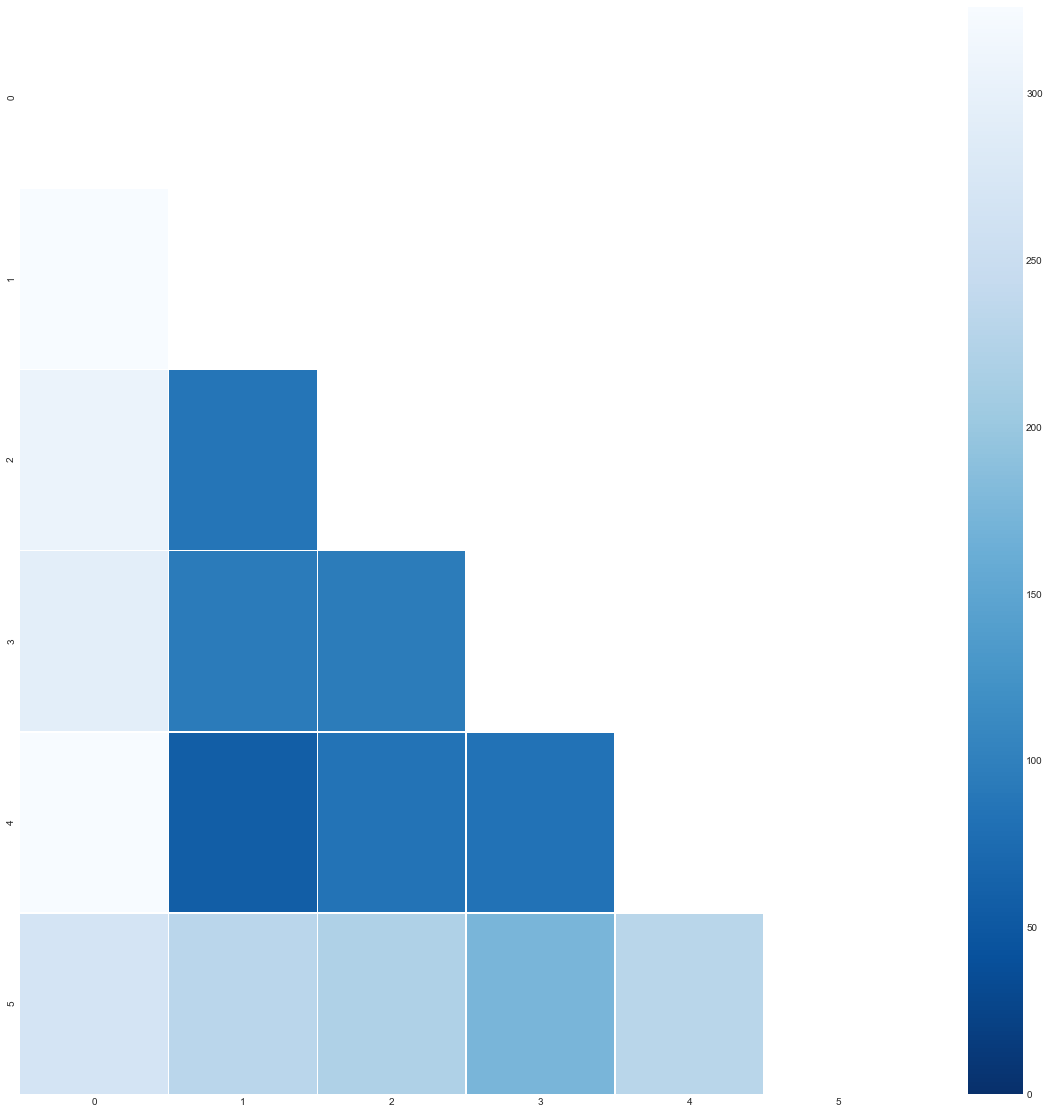


- Final number of prototypes:  6

# Finished in 0.7181 secs















In [41]:
max_numberOf_clusters= [10,50,100,500,1000]
max_editDistance= [50,100,200,300]
distanceMetric= ['edit']


ngramms= [3]  
jaccard_withchars = [True] 

# ---------------- #

distanceMetricEmbedding = ['euclidean']

windowSize= [50]
number_of_permutations = [5]

similarityThreshold= [0.7]
similarityVectors= ['ranked']
metric= ['kendal']





results = GridSearch_cora(data,true_matrix,max_numberOf_clusters,max_editDistance,
                          similarityThreshold,
                          windowSize,metric,similarityVectors,
                          distanceMetricEmbedding,
                          distanceMetric,number_of_permutations,
                          ngramms,jaccard_withchars)

In [ ]:
max_numberOf_clusters= [5,10,20]
max_editDistance= [50,100,200,300]
distanceMetric= ['edit']



# ----------------
distanceMetricEmbedding = ['euclidean']

windowSize= [50]
number_of_permutations = [1,3,5,7]

similarityThreshold= [0.7]
similarityVectors= ['ranked','initial']
metric= ['kendal']





results = GridSearch_cora(data,true_matrix,max_numberOf_clusters,max_editDistance,similarityThreshold,windowSize,metric,similarityVectors,distanceMetricEmbedding,distanceMetric,number_of_permutations)

## Performance details

### Embeddings

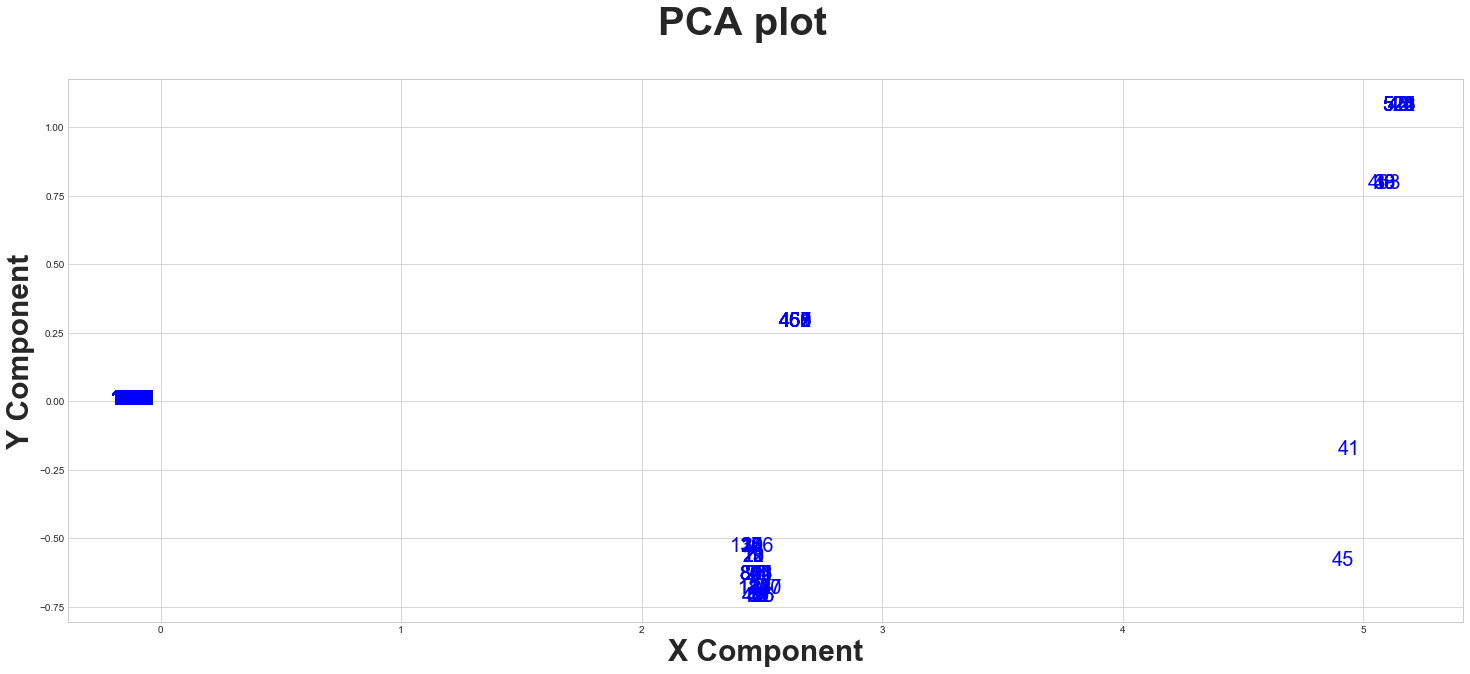

In [23]:
pcaComponents = PCA_SpaceVisualization(model.Embeddings)

In [ ]:
pcaComponents = PCA_SpaceVisualization(model.rankedVectors)

### Grid Search

In [ ]:
max_numberOf_clusters= [5,10,20]
max_editDistance= [50,100,200,300]
windowSize= [3, 5, 10, 15]
similarityThreshold= [0.6,0.7,0.8]
metric= ['kendal', 'customKendal','jaccard','pearson']
similarityVectors= ['ranked','initial']
distanceMetric= ['edit']
distanceMetricEmbedding = ['edit','euclidean']
number_of_permutations = [1,3,5,7]


# results = GridSearch_cora(data,true_matrix,max_numberOf_clusters,max_editDistance,similarityThreshold,windowSize,metric,similarityVectors,distanceMetricEmbedding,distanceMetric,number_of_permutations)

In [ ]:
# results.sort_values(by=['Accuracy'],ascending=False)

---

# References

1.   [The dissimilarity representation for pattern recognition, a tutorial
Robert P.W. Duin and Elzbieta Pekalska Delft University of Technology, The Netherlands School of Computer Science, University of Manchester, United Kingdom](http://homepage.tudelft.nl/a9p19/presentations/DisRep_Tutorial_doc.pdf)